<a href="https://colab.research.google.com/github/AyanAhmedKhan/Aircraft-Engine-Predictive-Maintenance/blob/main/aerospace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================================
# ADVANCED AIRCRAFT ENGINE PREDICTIVE MAINTENANCE
# =============================================

# Install required packages
!pip install -q tensorflow keras scikit-learn pandas numpy matplotlib seaborn
!pip install -q plotly scipy xgboost lightgbm shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import os
import zipfile
from pathlib import Path
import io
import shutil
from google.colab import files

In [ ]:
# =============================================
# 1. UPLOAD AND EXTRACT ZIP FILE
# =============================================

print("🔧 Preparing environment...")

# Create directories
!mkdir -p /content/data
!mkdir -p /content/models
!mkdir -p /content/results

def extract_uploaded_zip():
    """Handle uploaded zip file extraction"""
    print("📂 Please upload the 'archive.zip' file when prompted...")

    # Upload the file
    uploaded = files.upload()

    # Check if archive.zip was uploaded
    zip_filename = None
    for filename in uploaded.keys():
        if 'archive' in filename.lower() and filename.endswith('.zip'):
            zip_filename = filename
            break

    if zip_filename:
        print(f"✅ Found uploaded file: {zip_filename}")

        # Extract the zip file
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall('/content/data')

        print("📁 Extracted files:")
        extracted_files = os.listdir('/content/data')
        for file in extracted_files:
            print(f"   - {file}")

        return True
    else:
        print("❌ No archive.zip file found in upload. Checking for existing data...")

        # Check if data already exists
        if os.path.exists('/content/data'):
            print("✅ Found existing data directory")
            return True

        return False

# Try to extract uploaded zip
if not extract_uploaded_zip():
    print("⚠️ Using sample data...")
    # Download sample data as fallback
    !wget -q https://ti.arc.nasa.gov/c/6/f/train_FD001.txt -P /content/data/
    !wget -q https://ti.arc.nasa.gov/c/6/f/test_FD001.txt -P /content/data/

🔧 Preparing environment...
📂 Please upload the 'archive.zip' file when prompted...


Saving archive.zip to archive.zip
✅ Found uploaded file: archive.zip
📁 Extracted files:
   - readme.txt
   - RUL_FD003.txt
   - test_FD004.txt
   - RUL_FD002.txt
   - RUL_FD004.txt
   - RUL_FD001.txt
   - test_FD001.txt
   - train_FD001.txt
   - test_FD003.txt
   - train_FD002.txt
   - train_FD003.txt
   - Damage Propagation Modeling.pdf
   - test_FD002.txt
   - train_FD004.txt


In [ ]:
# =============================================
# 2. EXPLORE EXTRACTED DATA STRUCTURE
# =============================================

def explore_data_directory():
    """Explore what data we have available"""
    data_dir = Path('/content/data')
    files_found = list(data_dir.rglob('*'))

    print(f"\n📊 DATA DIRECTORY EXPLORATION")
    print(f"{'='*50}")

    # Group files by type
    txt_files = [f for f in files_found if f.suffix == '.txt']
    csv_files = [f for f in files_found if f.suffix == '.csv']
    other_files = [f for f in files_found if f.suffix not in ['.txt', '.csv']]

    print(f"Total files found: {len(files_found)}")
    print(f"Text files: {len(txt_files)}")
    print(f"CSV files: {len(csv_files)}")

    print("\n📋 Listing all files:")
    for i, file_path in enumerate(files_found[:20], 1):
        size_mb = file_path.stat().st_size / (1024 * 1024)
        print(f"  {i:2d}. {file_path.name:30} ({size_mb:.2f} MB)")

    if len(files_found) > 20:
        print(f"  ... and {len(files_found) - 20} more files")

    return files_found

files_found = explore_data_directory()


📊 DATA DIRECTORY EXPLORATION
Total files found: 14
Text files: 13
CSV files: 0

📋 Listing all files:
   1. readme.txt                     (0.00 MB)
   2. RUL_FD003.txt                  (0.00 MB)
   3. test_FD004.txt                 (6.64 MB)
   4. RUL_FD002.txt                  (0.00 MB)
   5. RUL_FD004.txt                  (0.00 MB)
   6. RUL_FD001.txt                  (0.00 MB)
   7. test_FD001.txt                 (2.13 MB)
   8. train_FD001.txt                (3.35 MB)
   9. test_FD003.txt                 (2.70 MB)
  10. train_FD002.txt                (8.66 MB)
  11. train_FD003.txt                (4.02 MB)
  12. Damage Propagation Modeling.pdf (0.41 MB)
  13. test_FD002.txt                 (5.47 MB)
  14. train_FD004.txt                (9.87 MB)


In [ ]:
# =============================================
# 3. DATA LOADER WITH AUTO-DETECTION
# =============================================

class AutoDataLoader:
    """Automatically detect and load NASA engine data"""

    def __init__(self):
        self.data_dir = Path('/content/data')
        self.datasets = {}

    def detect_datasets(self):
        """Auto-detect available datasets"""
        print("\n🔍 Auto-detecting datasets...")

        # Look for train/test files
        train_files = list(self.data_dir.rglob('*train*'))
        test_files = list(self.data_dir.rglob('*test*'))
        rul_files = list(self.data_dir.rglob('*RUL*'))

        # Standard NASA naming patterns
        patterns = {
            'FD001': ['train_FD001', 'test_FD001', 'RUL_FD001'],
            'FD002': ['train_FD002', 'test_FD002', 'RUL_FD002'],
            'FD003': ['train_FD003', 'test_FD003', 'RUL_FD003'],
            'FD004': ['train_FD004', 'test_FD004', 'RUL_FD004'],
        }

        for dataset, pattern in patterns.items():
            found_files = []
            for file_type in pattern:
                matches = list(self.data_dir.rglob(f'*{file_type}*'))
                if matches:
                    found_files.append(matches[0])

            if len(found_files) >= 2:  # At least train and test
                self.datasets[dataset] = {
                    'train': found_files[0] if len(found_files) > 0 else None,
                    'test': found_files[1] if len(found_files) > 1 else None,
                    'rul': found_files[2] if len(found_files) > 2 else None
                }
                print(f"✅ Found dataset {dataset}")

        if not self.datasets:
            print("⚠️ No standard datasets found. Looking for any data files...")
            # Try to load any data file
            all_files = list(self.data_dir.rglob('*.txt')) + list(self.data_dir.rglob('*.csv'))
            if all_files:
                self.datasets['UNKNOWN'] = {
                    'train': all_files[0],
                    'test': all_files[0] if len(all_files) > 1 else None,
                    'rul': all_files[1] if len(all_files) > 2 else None
                }

        return self.datasets

    def load_dataset(self, dataset_name='FD001'):
        """Load specific dataset"""
        if dataset_name not in self.datasets:
            print(f"❌ Dataset {dataset_name} not found")
            return None

        dataset_info = self.datasets[dataset_name]

        # Define column names based on NASA specification
        column_names = [
            'unit', 'cycle', 'setting1', 'setting2', 'setting3'
        ] + [f'sensor_{i:02d}' for i in range(1, 22)]

        def load_file(file_path, is_rul=False):
            """Load a single file"""
            if file_path is None:
                return None

            try:
                if is_rul:
                    df = pd.read_csv(file_path, header=None, names=['RUL'])
                else:
                    # Try different delimiters
                    try:
                        df = pd.read_csv(file_path, sep=' ', header=None, engine='python')
                    except:
                        df = pd.read_csv(file_path, sep='\t', header=None, engine='python')

                    # Clean up NaN columns
                    df = df.dropna(axis=1, how='all')

                    # Assign column names
                    if len(df.columns) <= len(column_names):
                        df.columns = column_names[:len(df.columns)]
                    else:
                        print(f"⚠️ File has {len(df.columns)} columns, expected <= {len(column_names)}")
                        df.columns = [f'col_{i}' for i in range(len(df.columns))]

                print(f"   Loaded {file_path.name}: {df.shape[0]} rows, {df.shape[1]} columns")
                return df
            except Exception as e:
                print(f"❌ Error loading {file_path}: {e}")
                return None

        print(f"\n📥 Loading dataset {dataset_name}...")
        train_df = load_file(dataset_info['train'])
        test_df = load_file(dataset_info['test'])
        rul_df = load_file(dataset_info['rul'], is_rul=True) if dataset_info['rul'] else None

        return train_df, test_df, rul_df

# Initialize and detect datasets
data_loader = AutoDataLoader()
available_datasets = data_loader.detect_datasets()

print(f"\n📦 Available datasets: {list(available_datasets.keys())}")


🔍 Auto-detecting datasets...
✅ Found dataset FD001
✅ Found dataset FD002
✅ Found dataset FD003
✅ Found dataset FD004

📦 Available datasets: ['FD001', 'FD002', 'FD003', 'FD004']


In [ ]:
# =============================================
# 4. IMPROVED ASYMMETRIC LOSS FUNCTIONS
# =============================================

import tensorflow as tf
from tensorflow.keras import backend as K

def nasa_asymmetric_mse(y_true, y_pred):
    """
    NASA-style asymmetric loss function
    Late predictions (under-prediction) penalized more than early predictions
    """
    error = y_pred - y_true

    # Piecewise penalty
    # For early predictions (negative error): penalty = 1
    # For late predictions (positive error): penalty = 5 (highly penalized)
    penalty = 1.0 + 4.0 * tf.cast(error > 0, tf.float32)

    return tf.reduce_mean(penalty * tf.square(error))

def nasa_scoring_function(y_true, y_pred):
    """
    Exact NASA scoring function for C-MAPSS
    S = sum_{i=1}^n s_i
    where s_i = exp(-d_i/13) - 1 for d_i < 0 (early)
          s_i = exp(d_i/10) - 1 for d_i >= 0 (late)
    d_i = predicted RUL - true RUL
    """
    d = y_pred - y_true

    # NASA piecewise exponential penalty
    score = tf.where(
        d < 0,
        tf.exp(-d / 13.0) - 1.0,
        tf.exp(d / 10.0) - 1.0
    )

    return tf.reduce_sum(score)

def early_warning_loss(y_true, y_pred, alpha=2.0):
    """
    Loss that strongly penalizes late predictions (missed failures)
    alpha: penalty multiplier for late predictions
    """
    error = y_pred - y_true

    # Strong penalty for late predictions
    penalty = tf.where(
        error > 0,
        alpha * (1.0 + tf.tanh(error / 5.0)),  # Late predictions
        1.0  # Early predictions
    )

    return tf.reduce_mean(penalty * tf.square(error))

def piecewise_rul_loss(y_true, y_pred):
    """
    Piecewise RUL loss based on NASA's approach
    Different penalties based on remaining life
    """
    error = y_pred - y_true

    # Define different regions
    # Critical region (RUL < 30): heavy penalty for being late
    # Warning region (30 <= RUL < 60): moderate penalty
    # Normal region (RUL >= 60): standard penalty

    # Get true RUL to determine region
    is_critical = tf.cast(y_true < 30, tf.float32)
    is_warning = tf.cast((y_true >= 30) & (y_true < 60), tf.float32)
    is_normal = tf.cast(y_true >= 60, tf.float32)

    # Different penalties for each region
    penalty = 1.0 + 10.0 * is_critical * tf.cast(error > 0, tf.float32) + \
              5.0 * is_warning * tf.cast(error > 0, tf.float32) + \
              2.0 * is_normal * tf.cast(error > 0, tf.float32)

    return tf.reduce_mean(penalty * tf.square(error))

In [ ]:
# =============================================
# 5. ADVANCED DATA PROCESSOR WITH FIXES
# =============================================

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

class AdvancedDataProcessor:
    """Advanced data processing with sensor filtering and engine-based splitting"""

    def __init__(self, train_df, test_df, rul_df=None, remove_noisy=True, dataset_name='FD001'):
        self.train_df = train_df.copy()
        self.test_df = test_df.copy()
        self.rul_df = rul_df.copy() if rul_df is not None else None
        self.scaler = None
        self.feature_columns = None
        self.remove_noisy = remove_noisy
        self.dataset_name = dataset_name

    def clean_data(self):
        """Clean and prepare data with NASA-style sensor filtering"""
        print(f"🧹 Cleaning data (NASA C-MAPSS style) for {self.dataset_name}...")

        # Remove any completely empty columns
        self.train_df = self.train_df.dropna(axis=1, how='all')
        self.test_df = self.test_df.dropna(axis=1, how='all')

        # NASA recommended noisy sensors to remove
        noisy_sensors_fd001 = [
            'sensor_01', 'sensor_05', 'sensor_06', 'sensor_10',
            'sensor_16', 'sensor_18', 'sensor_19'
        ]

        # General noisy sensors
        noisy_sensors_general = [
            'sensor_01', 'sensor_05', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19'
        ]

        # Identify all sensor columns
        self.sensor_cols = []
        for col in self.train_df.columns:
            if 'sensor' in str(col).lower():
                self.sensor_cols.append(col)

        # Remove noisy sensors if specified
        if self.remove_noisy:
            if self.dataset_name == 'FD001':
                sensors_to_remove = noisy_sensors_fd001
            else:
                sensors_to_remove = noisy_sensors_general

            # Only remove sensors that exist
            sensors_to_remove = [s for s in sensors_to_remove if s in self.sensor_cols]
            self.sensor_cols = [s for s in self.sensor_cols if s not in sensors_to_remove]
            print(f"   Removed {len(sensors_to_remove)} noisy sensors: {sensors_to_remove}")

        print(f"   Using {len(self.sensor_cols)} sensor columns")

        # Calculate RUL for training data with early warning
        if 'RUL' not in self.train_df.columns:
            self.calculate_train_rul_early()

        return self

    def calculate_train_rul_early(self, warning_threshold=30):
        """Calculate RUL with early warning penalty"""
        print("   Calculating training RUL with early warning...")

        # Find max cycle for each unit
        max_cycles = self.train_df.groupby('unit')['cycle'].max()

        # Calculate RUL
        def calculate_rul(row):
            rul = max_cycles[row['unit']] - row['cycle']
            # Add early warning penalty (makes model more conservative)
            if rul < warning_threshold:
                rul = rul * 0.8  # Penalize late cycles more
            return rul

        self.train_df['RUL'] = self.train_df.apply(calculate_rul, axis=1)

        # Clip RUL based on dataset
        if self.dataset_name == 'FD001':
            max_rul = 125  # Standard for C-MAPSS FD001
        else:
            max_rul = 150  # Longer for other datasets

        self.train_df['RUL'] = self.train_df['RUL'].clip(upper=max_rul)

        # Create binary failure indicator for classification
        self.train_df['failure_soon'] = (self.train_df['RUL'] <= 30).astype(int)

        print(f"   RUL range: {self.train_df['RUL'].min():.1f} to {self.train_df['RUL'].max():.1f}")

        return self

    def engineer_features_optimized(self, window_size=15):
        """Create optimized features for early failure detection"""
        print(f"🔧 Engineering optimized features (window={window_size})...")

        # Keep only critical features
        base_features = ['unit', 'cycle']
        if 'RUL' in self.train_df.columns:
            base_features.append('RUL')
        if 'failure_soon' in self.train_df.columns:
            base_features.append('failure_soon')

        # Create new dataframes
        train_features = self.train_df[base_features].copy()
        test_features = self.test_df[['unit', 'cycle']].copy()

        # Select only important sensor signals (based on NASA study)
        critical_sensors = [
            'sensor_02', 'sensor_03', 'sensor_04', 'sensor_07',
            'sensor_08', 'sensor_09', 'sensor_11', 'sensor_12',
            'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17',
            'sensor_20', 'sensor_21'
        ]

        # Use only sensors that exist and are not removed
        available_critical = [s for s in critical_sensors if s in self.sensor_cols]
        if not available_critical:
            # Fallback to original sensor columns
            available_critical = self.sensor_cols[:min(10, len(self.sensor_cols))]

        print(f"   Using {len(available_critical)} critical sensors")

        # Add sensor data
        for sensor in available_critical:
            if sensor in self.train_df.columns:
                train_features[sensor] = self.train_df[sensor]
            if sensor in self.test_df.columns:
                test_features[sensor] = self.test_df[sensor]

        # Calculate rate of change for critical sensors
        for unit in train_features['unit'].unique():
            unit_mask = train_features['unit'] == unit

            for sensor in available_critical[:8]:  # First 8 most important
                if sensor in train_features.columns:
                    # Rate of change
                    values = train_features.loc[unit_mask, sensor]
                    train_features.loc[unit_mask, f'{sensor}_roc'] = values.diff().fillna(0).values

                    # Acceleration (second derivative)
                    train_features.loc[unit_mask, f'{sensor}_acc'] = values.diff().diff().fillna(0).values

                    # Rolling statistics
                    train_features.loc[unit_mask, f'{sensor}_mean'] = values.rolling(
                        window=window_size, min_periods=1).mean().values
                    train_features.loc[unit_mask, f'{sensor}_std'] = values.rolling(
                        window=window_size, min_periods=1).std().fillna(0).values

        # Do the same for test data
        for unit in test_features['unit'].unique():
            unit_mask = test_features['unit'] == unit

            for sensor in available_critical[:8]:
                if sensor in test_features.columns:
                    values = test_features.loc[unit_mask, sensor]
                    test_features.loc[unit_mask, f'{sensor}_roc'] = values.diff().fillna(0).values
                    test_features.loc[unit_mask, f'{sensor}_acc'] = values.diff().diff().fillna(0).values
                    test_features.loc[unit_mask, f'{sensor}_mean'] = values.rolling(
                        window=window_size, min_periods=1).mean().values
                    test_features.loc[unit_mask, f'{sensor}_std'] = values.rolling(
                        window=window_size, min_periods=1).std().fillna(0).values

        # Create health indicator (composite feature)
        if len(available_critical) >= 3:
            # Weighted combination of key sensors
            hi_cols = available_critical[:3]
            train_features['health_indicator'] = 0
            for col in hi_cols:
                if col in train_features.columns:
                    train_features['health_indicator'] += train_features[col] * (1/len(hi_cols))

            # Normalize health indicator
            train_features['health_indicator'] = (
                train_features['health_indicator'] - train_features['health_indicator'].mean()
            ) / train_features['health_indicator'].std()

            # Do the same for test
            test_features['health_indicator'] = 0
            for col in hi_cols:
                if col in test_features.columns:
                    test_features['health_indicator'] += test_features[col] * (1/len(hi_cols))
            test_features['health_indicator'] = (
                test_features['health_indicator'] - test_features['health_indicator'].mean()
            ) / test_features['health_indicator'].std()

        # Add operational setting interactions if available
        if all(col in self.train_df.columns for col in ['setting1', 'setting2', 'setting3']):
            train_features['op_interaction'] = self.train_df['setting1'] * self.train_df['setting2'] * self.train_df['setting3']
            test_features['op_interaction'] = self.test_df['setting1'] * self.test_df['setting2'] * self.test_df['setting3']

        # Polynomial features for cycle
        train_features['cycle_sq'] = train_features['cycle'] ** 2
        train_features['cycle_sqrt'] = np.sqrt(train_features['cycle'])
        test_features['cycle_sq'] = test_features['cycle'] ** 2
        test_features['cycle_sqrt'] = np.sqrt(test_features['cycle'])

        # Update dataframes
        self.train_df = train_features
        self.test_df = test_features

        print(f"   Total optimized features: {len(self.train_df.columns)}")

        return self

    def normalize_data(self):
        """Normalize features"""
        print("📊 Normalizing data...")

        # Identify feature columns (exclude unit, cycle, RUL, failure_soon)
        exclude_cols = ['unit', 'cycle']
        if 'RUL' in self.train_df.columns:
            exclude_cols.append('RUL')
        if 'failure_soon' in self.train_df.columns:
            exclude_cols.append('failure_soon')

        self.feature_columns = [col for col in self.train_df.columns if col not in exclude_cols]

        # Initialize and fit scaler
        self.scaler = StandardScaler()
        self.train_df[self.feature_columns] = self.scaler.fit_transform(
            self.train_df[self.feature_columns])

        if not self.test_df.empty:
            self.test_df[self.feature_columns] = self.scaler.transform(
                self.test_df[self.feature_columns])

        print(f"   Normalized {len(self.feature_columns)} features")

        return self

    def prepare_sequences_with_engines(self, sequence_length=30):
        """Prepare sequences with engine IDs for proper validation split"""
        print(f"🔄 Creating sequences with engine IDs (length={sequence_length})...")

        X_seqs, y_seqs, engine_ids = [], [], []
        X_test_seqs, test_engines = [], []

        # Training sequences
        for unit in self.train_df['unit'].unique():
            unit_data = self.train_df[self.train_df['unit'] == unit]

            if len(unit_data) < sequence_length:
                continue

            for i in range(len(unit_data) - sequence_length):
                seq_features = unit_data[self.feature_columns].iloc[i:i+sequence_length].values
                target_rul = unit_data['RUL'].iloc[i+sequence_length-1]

                X_seqs.append(seq_features)
                y_seqs.append(target_rul)
                engine_ids.append(unit)  # Store engine ID

        # Test sequences (last sequence for each engine)
        for unit in self.test_df['unit'].unique():
            unit_data = self.test_df[self.test_df['unit'] == unit]

            if len(unit_data) >= sequence_length:
                seq = unit_data[self.feature_columns].iloc[-sequence_length:].values
            else:
                seq = unit_data[self.feature_columns].values
                pad_len = sequence_length - len(seq)
                seq = np.pad(seq, ((pad_len, 0), (0, 0)), 'edge')

            X_test_seqs.append(seq)
            test_engines.append(unit)

        X_train = np.array(X_seqs)
        y_train = np.array(y_seqs)
        X_test = np.array(X_test_seqs)

        print(f"   Training: {X_train.shape} sequences from {len(np.unique(engine_ids))} engines")
        print(f"   Test: {X_test.shape} sequences from {len(test_engines)} engines")

        return X_train, y_train, np.array(engine_ids), X_test, np.array(test_engines)

    def get_flat_features(self):
        """Get flattened features for tree-based models"""
        print("📈 Preparing flattened features...")

        # Group by unit and take the last observation
        train_flat = self.train_df.groupby('unit').last().reset_index()
        test_flat = self.test_df.groupby('unit').last().reset_index()

        # Prepare features and targets
        X_train_flat = train_flat[self.feature_columns].values
        y_train_flat = train_flat['RUL'].values if 'RUL' in train_flat.columns else None

        X_test_flat = test_flat[self.feature_columns].values

        print(f"   Flat training: {X_train_flat.shape}")
        print(f"   Flat test: {X_test_flat.shape}")

        return X_train_flat, y_train_flat, X_test_flat, test_flat['unit'].values

In [ ]:
# =============================================
# 6. TRANSFORMER POSITIONAL ENCODING (SAFE)
# =============================================

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, Bidirectional,
    Conv1D, MaxPooling1D, Flatten,
    Input, Concatenate,
    BatchNormalization, LayerNormalization,
    GlobalAveragePooling1D,
    MultiHeadAttention,
    RepeatVector, Permute, Multiply, Lambda, Softmax
)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1_l2

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, seq_len, feature_dim):
        super().__init__()
        self.pos_emb = self.add_weight(
            shape=(1, seq_len, feature_dim),
            initializer="random_normal",
            trainable=True
        )

    def call(self, x):
        return x + self.pos_emb

In [ ]:
# =============================================
# 7. IMPROVED MODEL ARCHITECTURES
# =============================================

class AdvancedRULModels:
    """Improved RUL prediction models with early warning"""

    def __init__(self, input_shape, dataset_name='FD001'):
        self.input_shape = input_shape
        self.dataset_name = dataset_name

        # Adjust architecture based on dataset
        if dataset_name == 'FD001':
            self.sequence_len = 30  # Shorter for FD001
            self.transformer_blocks = 2  # Deeper for FD001
        else:
            self.sequence_len = 50
            self.transformer_blocks = 1

    def build_lstm_attention_improved(self, lstm_units=128, dropout_rate=0.3):
        """Improved LSTM with Attention"""
        print("🔨 Building Improved LSTM + Attention model")

        inputs = Input(shape=self.input_shape)

        x = Bidirectional(LSTM(lstm_units, return_sequences=True))(inputs)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

        x = Bidirectional(LSTM(lstm_units // 2, return_sequences=True))(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

        # ---------- Attention ----------
        attention = Dense(1, activation="tanh")(x)
        attention = Flatten()(attention)
        attention = Softmax()(attention)

        feature_dim = x.shape[-1]
        attention = RepeatVector(feature_dim)(attention)
        attention = Permute([2, 1])(attention)

        x = Multiply()([x, attention])
        x = Lambda(lambda t: tf.reduce_sum(t, axis=1))(x)

        # ---------- Dense ----------
        x = Dense(64, activation="relu", kernel_regularizer=l1_l2(0.01, 0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate / 2)(x)

        x = Dense(32, activation="relu")(x)
        x = Dense(16, activation="relu")(x)

        output = Dense(1, activation="linear", name="RUL_output")(x)

        model = Model(inputs, output)
        model.compile(
            optimizer=Adam(0.001, clipnorm=1.0),
            loss=nasa_asymmetric_mse,  # Using NASA asymmetric loss
            metrics=["mae", "mse", tf.keras.metrics.RootMeanSquaredError()]
        )

        return model

    def build_transformer_improved(self, num_heads=4, key_dim=32):
        """Improved Transformer with early warning"""
        print(f"🔨 Building Improved Transformer (blocks={self.transformer_blocks})")

        seq_len, feature_dim = self.input_shape
        inputs = Input(shape=self.input_shape)

        # Positional encoding
        x = PositionalEncoding(seq_len, feature_dim)(inputs)

        # Multiple transformer blocks
        for i in range(self.transformer_blocks):
            # Self-attention
            attn_output = MultiHeadAttention(
                num_heads=num_heads,
                key_dim=key_dim,
                dropout=0.1
            )(x, x)

            # Add & Norm
            x = LayerNormalization(epsilon=1e-6)(x + attn_output)

            # Feed forward
            ffn_output = Dense(key_dim * 4, activation='relu')(x)
            ffn_output = Dense(feature_dim)(ffn_output)
            ffn_output = Dropout(0.1)(ffn_output)

            # Add & Norm
            x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

        # Global pooling
        x = GlobalAveragePooling1D()(x)

        # Early warning branch (binary classification)
        early_branch = Dense(32, activation='relu')(x)
        early_branch = Dropout(0.3)(early_branch)
        early_branch = Dense(16, activation='relu')(early_branch)
        early_output = Dense(1, activation='sigmoid', name='early_warning')(early_branch)

        # RUL regression branch
        rul_branch = Dense(64, activation='relu')(x)
        rul_branch = BatchNormalization()(rul_branch)
        rul_branch = Dropout(0.3)(rul_branch)

        rul_branch = Dense(32, activation='relu')(rul_branch)
        rul_branch = Dense(16, activation='relu')(rul_branch)
        rul_output = Dense(1, activation='linear', name='rul_prediction')(rul_branch)

        # Multi-output model
        model = Model(
            inputs=inputs,
            outputs=[rul_output, early_output]
        )

        # Multi-task loss (RUL + early warning)
        losses = {
            'rul_prediction': nasa_asymmetric_mse,
            'early_warning': 'binary_crossentropy'
        }

        loss_weights = {'rul_prediction': 1.0, 'early_warning': 0.3}

        model.compile(
            optimizer=Adam(0.001, clipnorm=1.0),
            loss=losses,
            loss_weights=loss_weights,
            metrics={
                'rul_prediction': ['mae', 'mse'],
                'early_warning': ['accuracy']
            }
        )

        return model

    def build_early_warning_ensemble(self):
        """Ensemble model with early warning focus"""
        print("🔨 Building Early Warning Ensemble")

        inputs = Input(shape=self.input_shape)

        # LSTM branch for temporal patterns
        lstm_branch = Bidirectional(LSTM(64, return_sequences=True))(inputs)
        lstm_branch = Dropout(0.3)(lstm_branch)
        lstm_branch = Bidirectional(LSTM(32, return_sequences=False))(lstm_branch)
        lstm_branch = Dense(16, activation='relu')(lstm_branch)

        # CNN branch for local patterns
        cnn_branch = Conv1D(64, 3, padding='same', activation='relu')(inputs)
        cnn_branch = BatchNormalization()(cnn_branch)
        cnn_branch = MaxPooling1D(2)(cnn_branch)
        cnn_branch = Conv1D(32, 3, padding='same', activation='relu')(cnn_branch)
        cnn_branch = GlobalAveragePooling1D()(cnn_branch)
        cnn_branch = Dense(16, activation='relu')(cnn_branch)

        # Combine branches
        combined = Concatenate()([lstm_branch, cnn_branch])

        # Shared layers
        x = Dense(32, activation='relu')(combined)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)

        # Two outputs
        rul_output = Dense(1, activation='linear', name='rul')(x)

        # Early warning (classification)
        warning_branch = Dense(16, activation='relu')(x)
        warning_output = Dense(1, activation='sigmoid', name='warning')(warning_branch)

        model = Model(inputs=inputs, outputs=[rul_output, warning_output])

        # Compile with asymmetric loss
        model.compile(
            optimizer=Adam(0.001),
            loss={
                'rul': nasa_asymmetric_mse,
                'warning': 'binary_crossentropy'
            },
            loss_weights={'rul': 1.0, 'warning': 0.5},
            metrics={'rul': ['mae', 'mse'], 'warning': ['accuracy']}
        )

        return model

    def build_cnn_lstm_asymmetric(self, filters=64, kernel_size=3):
        """CNN + LSTM Hybrid with asymmetric loss"""
        print("🔨 Building CNN + LSTM Hybrid with asymmetric loss")

        inputs = Input(shape=self.input_shape)

        x = Conv1D(filters, kernel_size, padding="same", activation="relu")(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling1D(2)(x)
        x = Dropout(0.2)(x)

        x = Conv1D(filters * 2, kernel_size, padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(2)(x)
        x = Dropout(0.2)(x)

        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Dropout(0.3)(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dropout(0.3)(x)

        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)

        x = Dense(32, activation="relu")(x)
        x = Dense(16, activation="relu")(x)

        output = Dense(1, activation="linear")(x)

        model = Model(inputs, output)
        model.compile(
            optimizer=RMSprop(0.001),
            loss=nasa_asymmetric_mse,  # Using asymmetric loss
            metrics=["mae", "mse"]
        )

        return model

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

class OptimizedModelTrainer:
    """Optimized trainer with engine-based validation and early warning focus"""

    def __init__(self, X_train, y_train, engine_ids, X_val=None, y_val=None):
        self.X_train = X_train
        self.y_train = y_train
        self.engine_ids = engine_ids
        self.X_val = X_val
        self.y_val = y_val
        self.models = {}
        self.histories = {}
        self.predictions = {}

    def prepare_validation(self, val_split=0.2, random_state=42):
        """Prepare validation data by ENGINE ID (no data leakage)"""
        print(f"🛡️ Creating validation split by ENGINE ID (no data leakage)...")

        # Use GroupShuffleSplit to ensure engines don't leak between train and val
        gss = GroupShuffleSplit(n_splits=1, test_size=val_split, random_state=random_state)

        # Get train/val indices based on engine groups
        for train_idx, val_idx in gss.split(self.X_train, self.y_train, groups=self.engine_ids):
            X_train_new = self.X_train[train_idx]
            y_train_new = self.y_train[train_idx]
            X_val_new = self.X_train[val_idx]
            y_val_new = self.y_train[val_idx]
            train_engines_new = self.engine_ids[train_idx]
            val_engines_new = self.engine_ids[val_idx]

        print(f"   Training engines: {len(np.unique(train_engines_new))}")
        print(f"   Validation engines: {len(np.unique(val_engines_new))}")
        print(f"   Training sequences: {X_train_new.shape}")
        print(f"   Validation sequences: {X_val_new.shape}")

        return X_train_new, y_train_new, X_val_new, y_val_new

    def get_callbacks(self, model_name):
        """Get training callbacks"""
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=20,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=1e-6,
                verbose=1
            ),
            ModelCheckpoint(
                f'/content/models/{model_name}_best.h5',
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            ),
            CSVLogger(f'/content/models/{model_name}_history.csv')
        ]

        return callbacks

    def train_early_warning_models(self, input_shape, epochs=100, batch_size=64, dataset_name='FD001'):
        """Train models optimized for early warning"""
        print("🔨 Training early-warning optimized models...")

        builder = AdvancedRULModels(input_shape, dataset_name)

        # Train different architectures optimized for early detection
        models_to_train = {
            'transformer_2block': builder.build_transformer_improved(),
            'early_warning_ensemble': builder.build_early_warning_ensemble(),
            'lstm_asymmetric': self.build_lstm_asymmetric(input_shape),
            'cnn_lstm_asymmetric': builder.build_cnn_lstm_asymmetric()
        }

        for name, model in models_to_train.items():
            try:
                print(f"\n🚂 Training {name}...")

                # Determine if it's a multi-output model more robustly
                is_multi_output = len(model.outputs) > 1

                if is_multi_output:
                    # For multi-output models, we need to provide multiple targets
                    y_train_warning = (self.y_train <= 30).astype(float).reshape(-1, 1)
                    y_val_warning = (self.y_val <= 30).astype(float).reshape(-1, 1)

                    train_targets = {}
                    val_targets = {}

                    # Get output names safely
                    output_names = model.output_names if hasattr(model, 'output_names') else []

                    # Fill target dictionaries based on output names
                    if 'rul_prediction' in output_names:
                        train_targets['rul_prediction'] = self.y_train
                        val_targets['rul_prediction'] = self.y_val
                    if 'early_warning' in output_names:
                        train_targets['early_warning'] = y_train_warning
                        val_targets['early_warning'] = y_val_warning

                    # Fallback for 'rul' and 'warning' names used in 'early_warning_ensemble'
                    if 'rul' in output_names:
                        train_targets['rul'] = self.y_train
                        val_targets['rul'] = self.y_val
                    if 'warning' in output_names:
                        train_targets['warning'] = y_train_warning
                        val_targets['warning'] = y_val_warning

                    # If after checking named outputs, targets are still empty (e.g., default names), assume order
                    if not train_targets and len(output_names) >= 2:
                        print(f"⚠️ Warning: Multi-output model '{name}' has default or unexpected output names. Assuming RUL for first output and Warning for second.")
                        train_targets[output_names[0]] = self.y_train
                        val_targets[output_names[0]] = self.y_val
                        train_targets[output_names[1]] = y_train_warning
                        val_targets[output_names[1]] = y_val_warning
                    elif not train_targets:
                        print(f"❌ Error: Could not determine targets for multi-output model '{name}'. Skipping.")
                        continue # Skip this model if targets can't be set

                    history = model.fit(
                        self.X_train,
                        train_targets,
                        validation_data=(self.X_val, val_targets),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=self.get_callbacks(name),
                        verbose=1
                    )
                else:
                    # Single output model
                    history = model.fit(
                        self.X_train, self.y_train,
                        validation_data=(self.X_val, self.y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=self.get_callbacks(name),
                        verbose=1
                    )

                self.models[name] = model
                self.histories[name] = history
                print(f"✅ {name} training completed")

            except Exception as e:
                print(f"❌ Error training {name}: {e}")
                import traceback
                traceback.print_exc()

        return self

    def build_lstm_asymmetric(self, input_shape):
        """LSTM model with asymmetric loss"""
        from tensorflow.keras.models import Sequential

        model = Sequential([
            Input(shape=input_shape),
            Bidirectional(LSTM(128, return_sequences=True)),
            Dropout(0.3),
            Bidirectional(LSTM(64)),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1, activation='linear')
        ])

        model.compile(
            optimizer=Adam(0.001),
            loss=nasa_asymmetric_mse,
            metrics=['mae', 'mse']
        )

        return model

    def evaluate_with_nasa_score(self, X_test, y_true):
        """Evaluate with NASA scoring function"""
        print(f"\n📊 MODEL EVALUATION WITH NASA SCORE")
        print("="*50)

        results = {}

        for name, model in self.models.items():
            print(f"\nEvaluating {name}...")

            # Make predictions
            y_pred_raw = model.predict(X_test)

            # Handle multi-output models
            if isinstance(y_pred_raw, list):
                y_pred = y_pred_raw[0].flatten()  # Take RUL prediction (assuming RUL is first output)
            else:
                y_pred = y_pred_raw.flatten()

            self.predictions[name] = y_pred

            # Calculate standard metrics
            from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            # NASA scoring function (corrected to avoid broadcasting issues)
            def nasa_score(true, pred):
                d = pred - true
                score_elements = np.zeros_like(d, dtype=float)

                negative_d_mask = d < 0
                positive_d_mask = d >= 0

                score_elements[negative_d_mask] = np.exp(-d[negative_d_mask] / 13.0) - 1.0
                score_elements[positive_d_mask] = np.exp(d[positive_d_mask] / 10.0) - 1.0

                return np.sum(score_elements) / len(true)  # Average score

            nasa = nasa_score(y_true, y_pred)

            # Early warning metrics
            if len(y_true) > 0:
                # Count late predictions (dangerous!)
                late_predictions = np.sum(y_pred > y_true + 5)  # More than 5 cycles late
                late_percentage = (late_predictions / len(y_true)) * 100

                # Count very late predictions (extremely dangerous)
                very_late = np.sum(y_pred > y_true + 20)
                very_late_percentage = (very_late / len(y_true)) * 100

                # Mean error (positive means late, negative means early)
                mean_error = np.mean(y_pred - y_true)

                results[name] = {
                    'RMSE': rmse,
                    'MAE': mae,
                    'R2': r2,
                    'NASA_Score': nasa,
                    'Late_Predictions_%': late_percentage,
                    'Very_Late_%': very_late_percentage,
                    'Mean_Error': mean_error,
                    'Std_Error': np.std(y_pred - y_true)
                }

                print(f"  RMSE: {rmse:.2f}")
                print(f"  MAE: {mae:.2f}")
                print(f"  R²: {r2:.3f}")
                print(f"  NASA Score: {nasa:.2f}")
                print(f"  Late Predictions (>5 cycles): {late_percentage:.1f}%")
                print(f"  Very Late (>20 cycles): {very_late_percentage:.1f}%")
                print(f"  Mean Error: {mean_error:.2f}")

                # Warning if model is consistently late
                if mean_error > 0:
                    print(f"  ⚠️ WARNING: Model is LATE on average!")
                else:
                    print(f"  ✅ Model is EARLY or accurate on average")

        # Create comparison dataframe
        results_df = pd.DataFrame(results).T
        results_df = results_df.sort_values('NASA_Score')

        print(f"\n🏆 MODEL RANKING (Lower NASA Score is better):")
        print(results_df[['RMSE', 'MAE', 'NASA_Score', 'Late_Predictions_%']])

        # Plot NASA score comparison
        self.plot_nasa_comparison(results_df)

        self.results_df = results_df
        return results_df

    def plot_nasa_comparison(self, results_df):
        """Plot NASA score comparison"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # NASA Score comparison
        axes[0].bar(range(len(results_df)), results_df['NASA_Score'].values)
        axes[0].set_xticks(range(len(results_df)))
        axes[0].set_xticklabels(results_df.index, rotation=45)
        axes[0].set_title('NASA Score (Lower is Better)')
        axes[0].set_ylabel('NASA Score')
        axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
        axes[0].grid(True, alpha=0.3)

        # Late predictions comparison
        axes[1].bar(range(len(results_df)), results_df['Late_Predictions_%'].values)
        axes[1].set_xticks(range(len(results_df)))
        axes[1].set_xticklabels(results_df.index, rotation=45)
        axes[1].set_title('Late Predictions % (Lower is Better)')
        axes[1].set_ylabel('Late Predictions %')
        axes[1].grid(True, alpha=0.3)

        # Mean Error comparison
        axes[2].bar(range(len(results_df)), results_df['Mean_Error'].values)
        axes[2].set_xticks(range(len(results_df)))
        axes[2].set_xticklabels(results_df.index, rotation=45)
        axes[2].set_title('Mean Error (Negative = Early)')
        axes[2].set_ylabel('Mean Error')
        axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def analyze_predictions(self, true_rul, dataset_name):
        """Analyze prediction errors for best model"""
        if not self.results_df.empty:
            best_model_name = self.results_df.index[0]
            best_pred = self.predictions[best_model_name]

            errors = best_pred - true_rul
            late_errors = errors[errors > 0]
            early_errors = errors[errors < 0]

            print(f"\n📊 PREDICTION ERROR ANALYSIS - {dataset_name}")
            print(f"   Best Model: {best_model_name}")
            print(f"   Total predictions: {len(errors)}")
            print(f"   Late predictions (dangerous): {len(late_errors)} ({len(late_errors)/len(errors)*100:.1f}%)")
            print(f"   Early predictions (safe): {len(early_errors)} ({len(early_errors)/len(errors)*100:.1f}%)")
            print(f"   Accurate predictions (±5 cycles): {np.sum(np.abs(errors) <= 5)} ({np.sum(np.abs(errors) <= 5)/len(errors)*100:.1f}%)")
            print(f"   Mean late error: {late_errors.mean():.2f} cycles" if len(late_errors) > 0 else "   No late predictions")
            print(f"   Mean early error: {-early_errors.mean():.2f} cycles" if len(early_errors) > 0 else "   No early predictions")

            # Plot error distribution
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Error histogram
            axes[0].hist(errors, bins=30, edgecolor='black', alpha=0.7)
            axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
            axes[0].axvline(x=-5, color='g', linestyle=':', linewidth=1, alpha=0.5)
            axes[0].axvline(x=5, color='g', linestyle=':', linewidth=1, alpha=0.5)
            axes[0].set_xlabel('Prediction Error (Predicted - True RUL)')
            axes[0].set_ylabel('Frequency')
            axes[0].set_title(f'{best_model_name} - Error Distribution')
            axes[0].grid(True, alpha=0.3)

            # Scatter plot
            axes[1].scatter(true_rul, best_pred, alpha=0.6, s=20)
            axes[1].plot([true_rul.min(), true_rul.max()],
                       [true_rul.min(), true_rul.max()], 'r--', lw=2)
            axes[1].fill_between([true_rul.min(), true_rul.max()],
                               [true_rul.min()-5, true_rul.max()-5],
                               [true_rul.min()+5, true_rul.max()+5],
                               color='green', alpha=0.1, label='±5 cycles')
            axes[1].set_xlabel('True RUL')
            axes[1].set_ylabel('Predicted RUL')
            axes[1].set_title(f'{best_model_name} - Predictions vs True')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

    def get_best_model(self):
        """Get the best performing model"""
        if not self.models:
            return None

        # Evaluate if not already done
        if not hasattr(self, 'results_df'):
            return list(self.models.values())[0]

        best_model_name = self.results_df.index[0]
        return self.models[best_model_name]

In [ ]:
# =============================================
# 9. INTERACTIVE DATA EXPLORATION
# =============================================

def interactive_data_exploration(train_df, dataset_name):
    """Create interactive visualizations"""
    print(f"\n📊 INTERACTIVE EXPLORATION - {dataset_name}")
    print("="*50)

    # Create dashboard
    fig = make_subplots(
        rows=3, cols=3,
        subplot_titles=('Engine Life Distribution', 'RUL Distribution',
                       'Sensor Correlations', 'Degradation Trend',
                       'Sensor Values Over Time', 'Operational Settings',
                       'Feature Importance', 'Cycle Distribution',
                       'Unit Statistics'),
        vertical_spacing=0.08,
        horizontal_spacing=0.08
    )

    # 1. Engine Life Distribution
    max_cycles = train_df.groupby('unit')['cycle'].max()
    fig.add_trace(
        go.Histogram(x=max_cycles, name='Max Cycles', nbinsx=30,
                     marker_color='skyblue'),
        row=1, col=1
    )

    # 2. RUL Distribution
    if 'RUL' in train_df.columns:
        fig.add_trace(
            go.Histogram(x=train_df['RUL'], name='RUL', nbinsx=30,
                         marker_color='lightcoral'),
            row=1, col=2
        )

    # 3. Sensor Correlations
    sensor_cols = [col for col in train_df.columns if 'sensor' in str(col).lower()]
    if sensor_cols and 'RUL' in train_df.columns:
        corrs = []
        for sensor in sensor_cols[:10]:  # Limit to 10 sensors
            corr = train_df[sensor].corr(train_df['RUL'])
            corrs.append((sensor, corr))

        corrs.sort(key=lambda x: abs(x[1]), reverse=True)
        sensors, correlations = zip(*corrs[:10])

        fig.add_trace(
            go.Bar(x=list(sensors), y=list(correlations), name='Correlation with RUL',
                   marker_color='lightgreen'),
            row=1, col=3
        )

    # 4. Degradation Trend
    sample_unit = train_df['unit'].iloc[0]
    unit_data = train_df[train_df['unit'] == sample_unit]
    fig.add_trace(
        go.Scatter(x=unit_data['cycle'], y=unit_data['RUL'] if 'RUL' in unit_data.columns else unit_data['cycle'],
                   mode='lines+markers', name=f'Unit {sample_unit}',
                   line=dict(color='orange', width=2)),
        row=2, col=1
    )

    # 5. Sensor Values Over Time
    if sensor_cols:
        sensor = sensor_cols[0]
        fig.add_trace(
            go.Scatter(x=unit_data['cycle'], y=unit_data[sensor],
                       mode='lines', name=f'{sensor}',
                       line=dict(color='purple', width=2)),
            row=2, col=2
        )

    # 6. Operational Settings (if available)
    op_settings = [col for col in train_df.columns if 'setting' in str(col).lower()]
    if op_settings:
        for i, setting in enumerate(op_settings[:3]):
            fig.add_trace(
                go.Scatter(x=unit_data['cycle'], y=unit_data[setting],
                           mode='lines', name=setting,
                           line=dict(width=1.5)),
                row=2, col=3
            )

    # Update layout
    fig.update_layout(
        height=900,
        showlegend=True,
        title_text=f"Dataset {dataset_name} - Interactive Dashboard",
        template='plotly_white'
    )

    fig.show()

    # Print statistics
    print(f"\n📈 DATASET STATISTICS:")
    print(f"   Total engines: {train_df['unit'].nunique()}")
    print(f"   Total cycles: {len(train_df)}")
    print(f"   Average cycles per engine: {train_df.groupby('unit')['cycle'].count().mean():.1f}")
    if 'RUL' in train_df.columns:
        print(f"   Average RUL: {train_df['RUL'].mean():.1f}")
        print(f"   Min RUL: {train_df['RUL'].min()}")
        print(f"   Max RUL: {train_df['RUL'].max()}")

    # Feature correlation matrix
    if len(sensor_cols) > 1:
        print(f"\n🔗 Feature correlations (top 10 sensors):")
        top_sensors = sensor_cols[:10]
        corr_matrix = train_df[top_sensors + (['RUL'] if 'RUL' in train_df.columns else [])].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                   square=True, cbar_kws={"shrink": 0.8})
        plt.title(f'Feature Correlation Matrix - {dataset_name}')
        plt.tight_layout()
        plt.show()

In [ ]:
# =============================================
# 10. OPTIMIZED WORKFLOW EXECUTION
# =============================================

def run_optimized_workflow(dataset_name='FD001'):
    """Run the complete optimized predictive maintenance workflow"""

    print(f"\n{'='*70}")
    print(f"🚀 OPTIMIZED PREDICTIVE MAINTENANCE WORKFLOW")
    print(f"🎯 Focus: EARLY FAILURE DETECTION")
    print(f"📊 DATASET: {dataset_name}")
    print(f"{'='*70}\n")

    # Step 1: Load data
    print("📥 STEP 1: Loading data...")
    train_df, test_df, rul_df = data_loader.load_dataset(dataset_name)

    if train_df is None:
        print(f"❌ Failed to load dataset {dataset_name}")
        return None

    # Step 2: Interactive exploration
    print("\n🔍 STEP 2: Data exploration...")
    interactive_data_exploration(train_df, dataset_name)

    # Step 3: Optimized processing
    print("\n⚙️ STEP 3: Optimized data processing...")
    processor = AdvancedDataProcessor(
        train_df, test_df, rul_df,
        remove_noisy=True,  # Remove noisy sensors
        dataset_name=dataset_name
    )
    processor.clean_data()
    processor.engineer_features_optimized(window_size=15)
    processor.normalize_data()

    # Step 4: Prepare sequences with engine IDs
    print("\n🔄 STEP 4: Preparing sequences with engine IDs...")

    # Adjust sequence length based on dataset
    if dataset_name == 'FD001':
        sequence_length = 30  # Shorter for FD001
    else:
        sequence_length = 50

    X_train, y_train, train_engines, X_test, test_engines = processor.prepare_sequences_with_engines(
        sequence_length=sequence_length
    )

    # Step 5: Train with proper validation split
    print("\n🎯 STEP 5: Training with engine-based validation...")
    trainer = OptimizedModelTrainer(X_train, y_train, train_engines)

    # Get proper validation split (no data leakage)
    X_train_split, y_train_split, X_val_split, y_val_split = trainer.prepare_validation(
        val_split=0.2, random_state=42
    )

    # Update trainer
    trainer.X_train = X_train_split
    trainer.y_train = y_train_split
    trainer.X_val = X_val_split
    trainer.y_val = y_val_split

    # Step 6: Train models optimized for early detection
    print("\n🔨 STEP 6: Training early-warning models...")
    input_shape = (X_train.shape[1], X_train.shape[2])
    trainer.train_early_warning_models(
        input_shape,
        epochs=100,
        batch_size=64,
        dataset_name=dataset_name
    )

    # Step 7: Evaluate with NASA score
    print("\n📈 STEP 7: Evaluating models with NASA score...")
    if rul_df is not None and len(rul_df) == len(X_test):
        true_rul = rul_df['RUL'].values
        results_df = trainer.evaluate_with_nasa_score(X_test, true_rul)
        trainer.results_df = results_df

        # Step 8: Analyze predictions
        trainer.analyze_predictions(true_rul, dataset_name)
    else:
        print("⚠️ No true RUL available for test data")
        # Use last RUL from test data if available
        if 'RUL' in test_df.columns:
            true_rul = test_df.groupby('unit')['RUL'].last().values
            results_df = trainer.evaluate_with_nasa_score(X_test, true_rul)
            trainer.results_df = results_df
            trainer.analyze_predictions(true_rul, dataset_name)

    # Step 9: Save best model
    print("\n💾 STEP 8: Saving best model...")
    best_model = trainer.get_best_model()
    if best_model:
        best_model.save(f'/content/models/best_model_early_warning_{dataset_name}.h5')
        print(f"✅ Best model saved to /content/models/best_model_early_warning_{dataset_name}.h5")

    # Step 10: Create deployment package
    print("\n🚀 STEP 9: Creating deployment package...")
    create_deployment_package(processor, best_model, dataset_name)

    print(f"\n{'='*70}")
    print(f"✅ OPTIMIZED WORKFLOW COMPLETE FOR {dataset_name}")
    print(f"{'='*70}")

    return trainer, processor

def create_deployment_package(processor, model, dataset_name):
    """Create a deployment package"""
    print("📦 Creating deployment package...")

    deployment_dir = f'/content/deployment_{dataset_name}'
    !mkdir -p {deployment_dir}

    # Save scaler
    import joblib
    if processor.scaler:
        joblib.dump(processor.scaler, f'{deployment_dir}/scaler.pkl')

    # Save feature columns
    if processor.feature_columns:
        pd.Series(processor.feature_columns).to_csv(
            f'{deployment_dir}/feature_columns.csv', index=False)

    # Save model summary
    if model:
        with open(f'{deployment_dir}/model_summary.txt', 'w') as f:
            model.summary(print_fn=lambda x: f.write(x + '\n'))

    # Create deployment script
    deployment_script = '''
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

class EngineRULPredictor:
    """Deployment-ready RUL predictor with early warning"""

    def __init__(self, model_path, scaler_path, features_path):
        self.model = load_model(model_path, custom_objects={
            'nasa_asymmetric_mse': nasa_asymmetric_mse
        })
        self.scaler = joblib.load(scaler_path)
        self.feature_columns = pd.read_csv(features_path, header=None)[0].tolist()

    def nasa_asymmetric_mse(y_true, y_pred):
        """NASA-style asymmetric loss function"""
        import tensorflow as tf
        error = y_pred - y_true
        penalty = 1.0 + 4.0 * tf.cast(error > 0, tf.float32)
        return tf.reduce_mean(penalty * tf.square(error))

    def predict_with_confidence(self, engine_data, sequence_length=30):
        """Predict RUL with confidence interval"""
        # Preprocess the data
        processed = self._preprocess(engine_data)

        # Create sequence
        if len(processed) >= sequence_length:
            sequence = processed[-sequence_length:]
        else:
            sequence = np.pad(processed,
                            ((sequence_length - len(processed), 0), (0, 0)),
                            'edge')

        # Predict
        prediction = self.model.predict(sequence[np.newaxis, ...])

        # Handle multi-output models
        if isinstance(prediction, list):
            rul_pred = prediction[0][0][0]
            warning_prob = prediction[1][0][0] if len(prediction) > 1 else 0.5
        else:
            rul_pred = prediction[0][0]
            warning_prob = 0.5

        # Calculate confidence (simplified)
        confidence = max(0.7, 1.0 - warning_prob)  # Higher confidence if no warning

        return rul_pred, confidence, warning_prob

    def _preprocess(self, data):
        """Preprocess engine data"""
        # Ensure data has correct features
        if data.shape[1] != len(self.feature_columns):
            raise ValueError(f"Expected {len(self.feature_columns)} features, got {data.shape[1]}")

        scaled = self.scaler.transform(data)
        return scaled

    def batch_predict(self, engines_data):
        """Predict RUL for multiple engines"""
        predictions = []
        confidences = []
        warnings = []

        for engine_data in engines_data:
            pred, conf, warn = self.predict_with_confidence(engine_data)
            predictions.append(pred)
            confidences.append(conf)
            warnings.append(warn)

        return np.array(predictions), np.array(confidences), np.array(warnings)

# Usage example:
# predictor = EngineRULPredictor('model.h5', 'scaler.pkl', 'feature_columns.csv')
# rul, confidence, warning = predictor.predict_with_confidence(engine_data)
'''

    with open(f'{deployment_dir}/predictor.py', 'w') as f:
        f.write(deployment_script)

    # Create requirements file
    requirements = '''
tensorflow>=2.8.0
pandas>=1.3.0
numpy>=1.21.0
scikit-learn>=1.0.0
joblib>=1.1.0
'''

    with open(f'{deployment_dir}/requirements.txt', 'w') as f:
        f.write(requirements)

    print(f"✅ Deployment package created in {deployment_dir}")

    # Create a zip file
    !cd /content && zip -r deployment_package_{dataset_name}.zip deployment_{dataset_name}

    print(f"📦 Zip file created: /content/deployment_package_{dataset_name}.zip")

    return deployment_dir

In [ ]:
# =============================================
# 11. MULTI-DATASET ANALYSIS
# =============================================

def analyze_all_datasets():
    """Analyze all available datasets"""
    print("\n📊 ANALYZING ALL AVAILABLE DATASETS")
    print("="*50)

    results = {}

    for dataset_name in available_datasets.keys():
        print(f"\n🔍 Processing {dataset_name}...")

        try:
            # Run optimized workflow
            trainer, processor = run_optimized_workflow(dataset_name)

            if trainer and hasattr(trainer, 'results_df'):
                results[dataset_name] = trainer.results_df

                # Save results
                trainer.results_df.to_csv(f'/content/results/results_{dataset_name}.csv')

                print(f"✅ {dataset_name} analysis complete")
            else:
                print(f"⚠️ {dataset_name} analysis incomplete")

        except Exception as e:
            print(f"❌ Error processing {dataset_name}: {e}")
            import traceback
            traceback.print_exc()

    # Compare results across datasets
    if results:
        print("\n🏆 DATASET COMPARISON")
        print("="*50)

        comparison_data = []
        for dataset, result_df in results.items():
            best_model = result_df.iloc[0]
            comparison_data.append({
                'Dataset': dataset,
                'Best Model': result_df.index[0],
                'RMSE': best_model['RMSE'],
                'MAE': best_model['MAE'],
                'NASA_Score': best_model['NASA_Score'],
                'Late_%': best_model['Late_Predictions_%']
            })

        comparison_df = pd.DataFrame(comparison_data)
        print("\n" + comparison_df.to_string(index=False))

        # Plot comparison
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        axes[0, 0].bar(range(len(comparison_df)), comparison_df['RMSE'])
        axes[0, 0].set_xticks(range(len(comparison_df)))
        axes[0, 0].set_xticklabels(comparison_df['Dataset'], rotation=45)
        axes[0, 0].set_title('RMSE Comparison (Lower is Better)')
        axes[0, 0].set_ylabel('RMSE')
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].bar(range(len(comparison_df)), comparison_df['MAE'])
        axes[0, 1].set_xticks(range(len(comparison_df)))
        axes[0, 1].set_xticklabels(comparison_df['Dataset'], rotation=45)
        axes[0, 1].set_title('MAE Comparison (Lower is Better)')
        axes[0, 1].set_ylabel('MAE')
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].bar(range(len(comparison_df)), comparison_df['NASA_Score'])
        axes[1, 0].set_xticks(range(len(comparison_df)))
        axes[1, 0].set_xticklabels(comparison_df['Dataset'], rotation=45)
        axes[1, 0].set_title('NASA Score (Lower is Better)')
        axes[1, 0].set_ylabel('NASA Score')
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].bar(range(len(comparison_df)), comparison_df['Late_%'])
        axes[1, 1].set_xticks(range(len(comparison_df)))
        axes[1, 1].set_xticklabels(comparison_df['Dataset'], rotation=45)
        axes[1, 1].set_title('Late Predictions % (Lower is Better)')
        axes[1, 1].set_ylabel('Late Predictions %')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return results


🤖 ADVANCED AIRCRAFT ENGINE PREDICTIVE MAINTENANCE SYSTEM
🎯 OPTIMIZED FOR EARLY FAILURE DETECTION

📁 Available datasets: ['FD001', 'FD002', 'FD003', 'FD004']

🚀 OPTIMIZED PREDICTIVE MAINTENANCE WORKFLOW
🎯 Focus: EARLY FAILURE DETECTION
📊 DATASET: FD002

📥 STEP 1: Loading data...

📥 Loading dataset FD002...
   Loaded train_FD002.txt: 53759 rows, 26 columns
   Loaded test_FD002.txt: 33991 rows, 26 columns
   Loaded RUL_FD002.txt: 259 rows, 1 columns

🔍 STEP 2: Data exploration...

📊 INTERACTIVE EXPLORATION - FD002



📈 DATASET STATISTICS:
   Total engines: 260
   Total cycles: 53759
   Average cycles per engine: 206.8

🔗 Feature correlations (top 10 sensors):


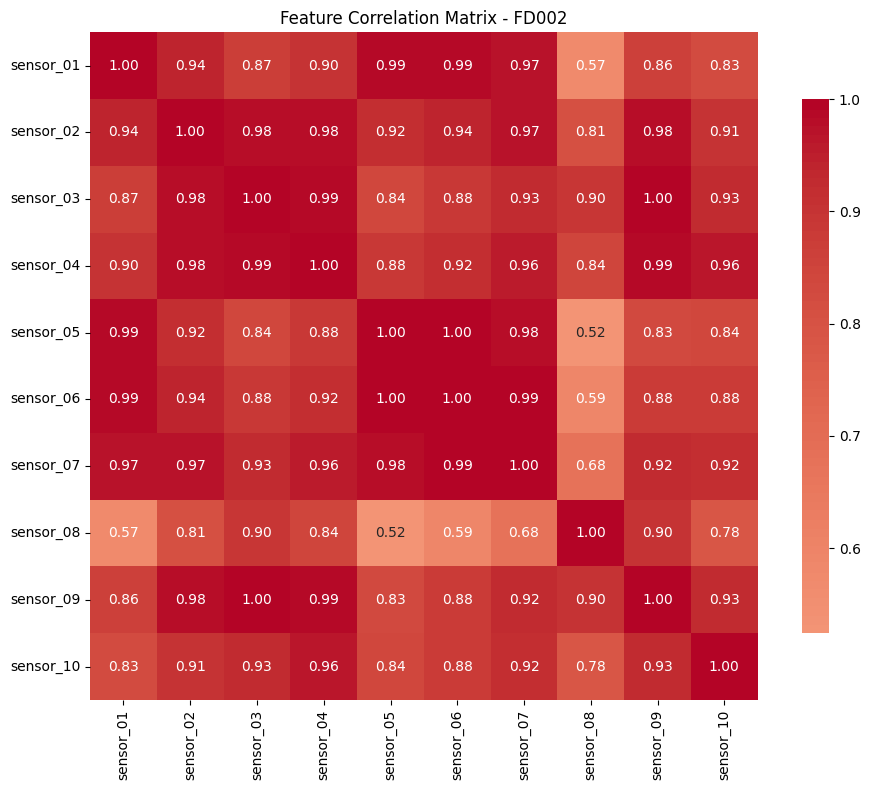


⚙️ STEP 3: Optimized data processing...
🧹 Cleaning data (NASA C-MAPSS style) for FD002...
   Removed 6 noisy sensors: ['sensor_01', 'sensor_05', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
   Using 15 sensor columns
   Calculating training RUL with early warning...
   RUL range: 0.0 to 150.0
🔧 Engineering optimized features (window=15)...
   Using 14 critical sensors
   Total optimized features: 54
📊 Normalizing data...
   Normalized 50 features

🔄 STEP 4: Preparing sequences with engine IDs...
🔄 Creating sequences with engine IDs (length=50)...
   Training: (40759, 50, 50) sequences from 260 engines
   Test: (259, 50, 50) sequences from 259 engines

🎯 STEP 5: Training with engine-based validation...
🛡️ Creating validation split by ENGINE ID (no data leakage)...
   Training engines: 208
   Validation engines: 52
   Training sequences: (33064, 50, 50)
   Validation sequences: (7695, 50, 50)

🔨 STEP 6: Training early-warning models...
🔨 Training early-warning optimized models...

517/517 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - early_warning_accuracy: 0.7967 - early_warning_loss: 0.4081 - loss: 4412.7681 - rul_prediction_loss: 4412.6401 - rul_prediction_mae: 50.0078 - rul_prediction_mse: 4159.7358 - val_early_warning_accuracy: 0.8972 - val_early_warning_loss: 0.2353 - val_loss: 1293.8684 - val_rul_prediction_loss: 1295.0782 - val_rul_prediction_mae: 21.7143 - val_rul_prediction_mse: 825.0873 - learning_rate: 0.0010
Epoch 2/100
513/517 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - early_warning_accuracy: 0.8915 - early_warning_loss: 0.2402 - loss: 1616.4098 - rul_prediction_loss: 1616.3378 - rul_prediction_mae: 26.1921 - rul_prediction_mse: 1174.4224
Epoch 2: val_loss did not improve from 1293.86841
517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - early_warning_accuracy: 0.8916 - early_warning_loss: 0.2400 - loss: 1615.8506 - rul_prediction_loss: 1615.7795 - rul_prediction_mae: 26.1875 - rul_prediction_mse: 1174.0801 - val_early_warning_accuracy: 0.8920 - val_early_warning_loss: 0.2

517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - early_warning_accuracy: 0.9173 - early_warning_loss: 0.1883 - loss: 1233.6030 - rul_prediction_loss: 1233.5468 - rul_prediction_mae: 22.3969 - rul_prediction_mse: 877.4639 - val_early_warning_accuracy: 0.9114 - val_early_warning_loss: 0.2017 - val_loss: 1268.7251 - val_rul_prediction_loss: 1263.3666 - val_rul_prediction_mae: 20.4299 - val_rul_prediction_mse: 755.9075 - learning_rate: 0.0010
Epoch 5/100
513/517 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - early_warning_accuracy: 0.9199 - early_warning_loss: 0.1784 - loss: 1093.3458 - rul_prediction_loss: 1093.2917 - rul_prediction_mae: 21.1247 - rul_prediction_mse: 783.0998
Epoch 5: val_loss did not improve from 1268.72510
517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - early_warning_accuracy: 0.9199 - early_warning_loss: 0.1784 - loss: 1093.1886 - rul_prediction_loss: 1093.1335 - rul_prediction_mae: 21.1227 - rul_prediction_mse: 782.9521 - val_early_warning_accuracy: 0.9125 - val_early_warning_loss: 0.1907 -

517/517 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 7924.4722 - rul_loss: 7924.2559 - rul_mae: 78.1756 - rul_mse: 7924.2632 - warning_accuracy: 0.7724 - warning_loss: 0.4134 - val_loss: 4121.4702 - val_rul_loss: 4100.2046 - val_rul_mae: 58.0080 - val_rul_mse: 4121.2417 - val_warning_accuracy: 0.9107 - val_warning_loss: 0.1980 - learning_rate: 0.0010
Epoch 2/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3312.4363 - rul_loss: 3312.3530 - rul_mae: 52.5561 - rul_mse: 3311.5076 - warning_accuracy: 0.9298 - warning_loss: 0.1653
Epoch 2: val_loss improved from 4121.47021 to 1549.45520, saving model to /content/models/early_warning_ensemble_best.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 3308.9722 - rul_loss: 3308.8848 - rul_mae: 52.5234 - rul_mse: 3308.0305 - warning_accuracy: 0.9299 - warning_loss: 0.1653 - val_loss: 1549.4552 - val_rul_loss: 1541.7770 - val_rul_mae: 28.4809 - val_rul_mse: 1286.2917 - val_warning_accuracy: 0.9237 - val_warning_loss: 0.2041 - learning_rate: 0.0010
Epoch 3/100
515/517 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 782.4315 - rul_loss: 782.3639 - rul_mae: 22.4317 - rul_mse: 729.0393 - warning_accuracy: 0.9419 - warning_loss: 0.1351
Epoch 3: val_loss did not improve from 1549.45520
517/517 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 781.6000 - rul_loss: 781.5336 - rul_mae: 22.4123 - rul_mse: 728.0581 - warning_accuracy: 0.9419 - warning_loss: 0.1351 - val_loss: 1570.9492 - val_rul_loss: 1569.0221 - val_rul_mae: 23.4107 - val_rul_mse: 1018.4641 - val_warning_accuracy: 0.9345 - val_warning_loss: 0.2048 - learning_rate: 0.0010
Epoch 4/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 452.6004

517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 328.6249 - rul_loss: 328.5861 - rul_mae: 12.0670 - rul_mse: 238.4895 - warning_accuracy: 0.9640 - warning_loss: 0.0827 - val_loss: 1526.8470 - val_rul_loss: 1522.7783 - val_rul_mae: 19.8411 - val_rul_mse: 751.3840 - val_warning_accuracy: 0.9324 - val_warning_loss: 0.2150 - learning_rate: 0.0010
Epoch 8/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 326.3268 - rul_loss: 326.2835 - rul_mae: 12.1194 - rul_mse: 239.6606 - warning_accuracy: 0.9636 - warning_loss: 0.0866
Epoch 8: val_loss did not improve from 1526.84705
517/517 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 326.3175 - rul_loss: 326.2744 - rul_mae: 12.1190 - rul_mse: 239.6458 - warning_accuracy: 0.9636 - warning_loss: 0.0866 - val_loss: 2799.6387 - val_rul_loss: 2830.6536 - val_rul_mae: 20.5638 - val_rul_mse: 799.6087 - val_warning_accuracy: 0.9203 - val_warning_loss: 0.3765 - learning_rate: 0.0010
Epoch 9/100
515/517 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 308.1130 - ru

517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 4849.6387 - mae: 51.8922 - mse: 4172.0312 - val_loss: 1259.0858 - val_mae: 21.5068 - val_mse: 805.1536 - learning_rate: 0.0010
Epoch 2/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1505.8406 - mae: 25.6180 - mse: 1110.5939
Epoch 2: val_loss did not improve from 1259.08582
517/517 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1505.5627 - mae: 25.6154 - mse: 1110.3844 - val_loss: 1446.3167 - val_mae: 20.1009 - val_mse: 709.8151 - learning_rate: 0.0010
Epoch 3/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1155.6238 - mae: 22.1851 - mse: 843.7830
Epoch 3: val_loss did not improve from 1259.08582
517/517 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1155.4268 - mae: 22.1829 - mse: 843.6430 - val_loss: 1291.1064 - val_mae: 21.1960 - val_mse: 839.9968 - learning_rate: 0.0010
Epoch 4/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 697.3565 - mae: 16.9789 - mse: 511.4418
Epoch 4: val_loss did not improve from 1259.08582
517/517 ━━

517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 4320.0771 - mae: 49.5694 - mse: 4078.6665 - val_loss: 1524.8771 - val_mae: 26.1649 - val_mse: 1149.6201 - learning_rate: 0.0010
Epoch 2/100
515/517 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1722.9447 - mae: 27.8411 - mse: 1311.7377
Epoch 2: val_loss did not improve from 1524.87708
517/517 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 1722.2026 - mae: 27.8332 - mse: 1311.0699 - val_loss: 1584.4382 - val_mae: 25.8587 - val_mse: 1216.0541 - learning_rate: 0.0010
Epoch 3/100
515/517 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1330.2113 - mae: 24.0015 - mse: 990.9126
Epoch 3: val_loss did not improve from 1524.87708
517/517 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 1329.6536 - mae: 23.9962 - mse: 990.5048 - val_loss: 1899.6804 - val_mae: 22.4359 - val_mse: 893.2797 - learning_rate: 0.0010
Epoch 4/100
514/517 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1035.2552 - mae: 21.1218 - mse: 766.1494
Epoch 4: val_loss did not improve from 1524.87708
517/517

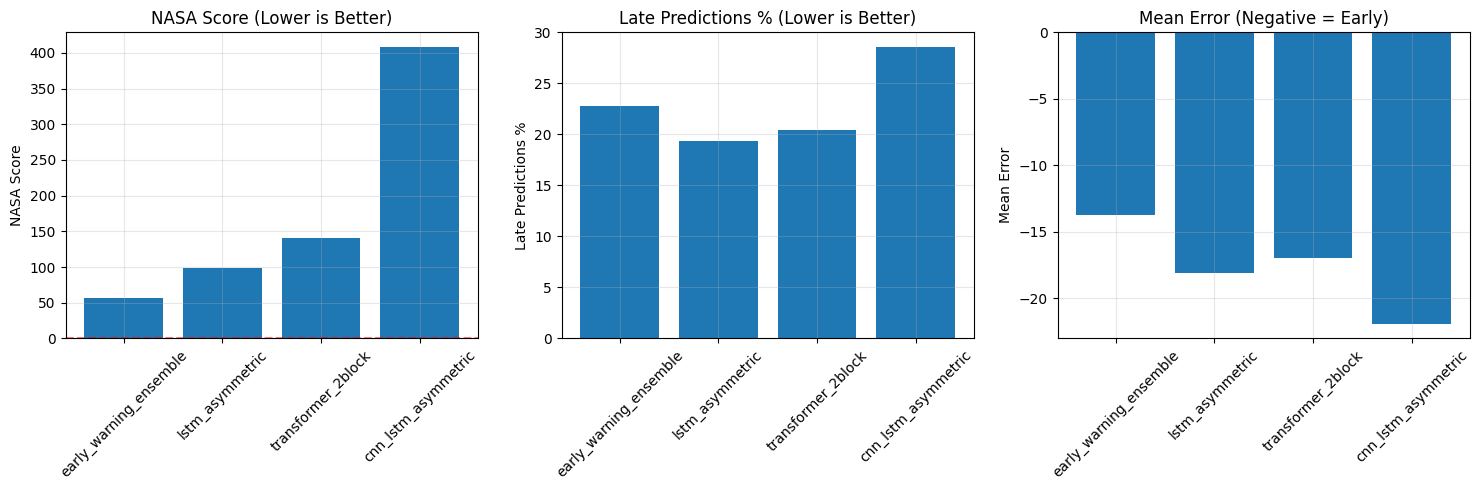


📊 PREDICTION ERROR ANALYSIS - FD002
   Best Model: early_warning_ensemble
   Total predictions: 259
   Late predictions (dangerous): 77 (29.7%)
   Early predictions (safe): 182 (70.3%)
   Accurate predictions (±5 cycles): 38 (14.7%)
   Mean late error: 15.82 cycles
   Mean early error: 26.26 cycles


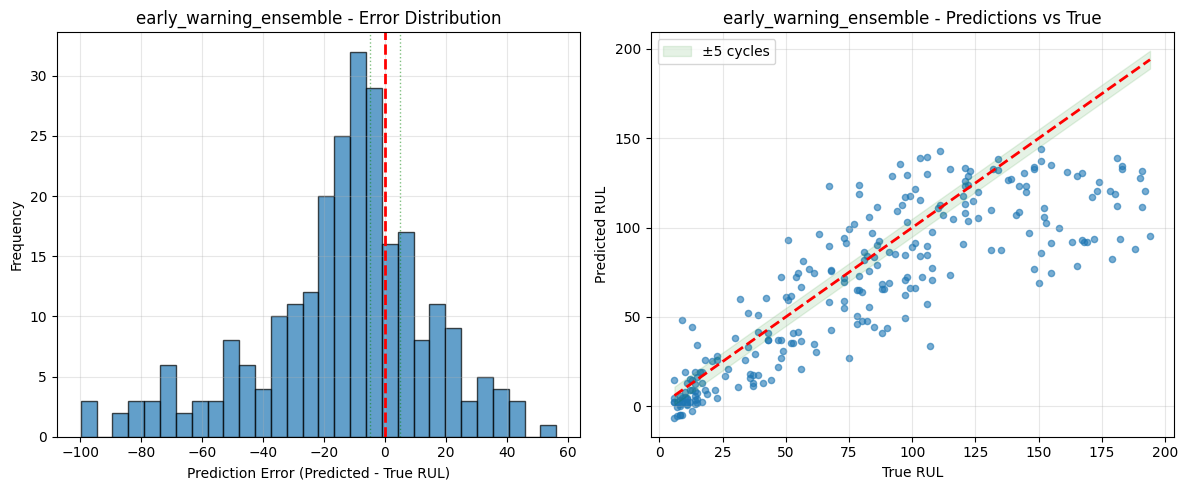


💾 STEP 8: Saving best model...
✅ Best model saved to /content/models/best_model_early_warning_FD002.h5

🚀 STEP 9: Creating deployment package...
📦 Creating deployment package...


✅ Deployment package created in /content/deployment_FD002
  adding: deployment_FD002/ (stored 0%)
  adding: deployment_FD002/model_summary.txt (deflated 89%)
  adding: deployment_FD002/feature_columns.csv (deflated 74%)
  adding: deployment_FD002/predictor.py (deflated 64%)
  adding: deployment_FD002/requirements.txt (deflated 14%)
  adding: deployment_FD002/scaler.pkl (deflated 31%)
📦 Zip file created: /content/deployment_package_FD002.zip

✅ OPTIMIZED WORKFLOW COMPLETE FOR FD002

📊 ANALYZING ALL AVAILABLE DATASETS

🔍 Processing FD001...

🚀 OPTIMIZED PREDICTIVE MAINTENANCE WORKFLOW
🎯 Focus: EARLY FAILURE DETECTION
📊 DATASET: FD001

📥 STEP 1: Loading data...

📥 Loading dataset FD001...
   Loaded train_FD001.txt: 20631 rows, 26 columns
   Loaded test_FD001.txt: 13096 rows, 26 columns
   Loaded RUL_FD001.txt: 100 rows, 1 columns

🔍 STEP 2: Data exploration...

📊 INTERACTIVE EXPLORATION - FD001



📈 DATASET STATISTICS:
   Total engines: 100
   Total cycles: 20631
   Average cycles per engine: 206.3

🔗 Feature correlations (top 10 sensors):


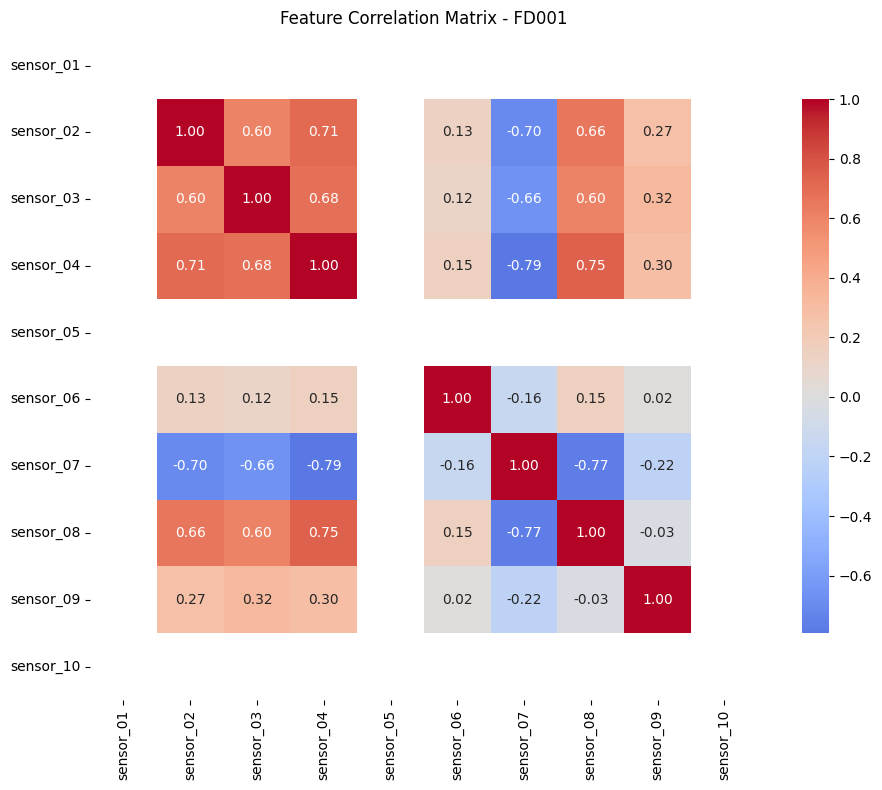


⚙️ STEP 3: Optimized data processing...
🧹 Cleaning data (NASA C-MAPSS style) for FD001...
   Removed 7 noisy sensors: ['sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
   Using 14 sensor columns
   Calculating training RUL with early warning...
   RUL range: 0.0 to 125.0
🔧 Engineering optimized features (window=15)...
   Using 14 critical sensors
   Total optimized features: 54
📊 Normalizing data...
   Normalized 50 features

🔄 STEP 4: Preparing sequences with engine IDs...
🔄 Creating sequences with engine IDs (length=30)...
   Training: (17631, 30, 50) sequences from 100 engines
   Test: (100, 30, 50) sequences from 100 engines

🎯 STEP 5: Training with engine-based validation...
🛡️ Creating validation split by ENGINE ID (no data leakage)...
   Training engines: 80
   Validation engines: 20
   Training sequences: (14161, 30, 50)
   Validation sequences: (3470, 30, 50)

🔨 STEP 6: Training early-warning models...
🔨 Training early-warning optimiz

222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - early_warning_accuracy: 0.7260 - early_warning_loss: 0.4684 - loss: 5177.9136 - rul_prediction_loss: 5177.7129 - rul_prediction_mae: 59.2712 - rul_prediction_mse: 5119.4414 - val_early_warning_accuracy: 0.9524 - val_early_warning_loss: 0.1083 - val_loss: 711.2620 - val_rul_prediction_loss: 701.3751 - val_rul_prediction_mae: 20.0185 - val_rul_prediction_mse: 621.8978 - learning_rate: 0.0010
Epoch 2/100
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - early_warning_accuracy: 0.9572 - early_warning_loss: 0.1062 - loss: 722.0867 - rul_prediction_loss: 722.0549 - rul_prediction_mae: 16.8939 - rul_prediction_mse: 472.4263
Epoch 2: val_loss did not improve from 711.26196
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - early_warning_accuracy: 0.9572 - early_warning_loss: 0.1062 - loss: 721.3895 - rul_prediction_loss: 721.3632 - rul_prediction_mae: 16.8918 - rul_prediction_mse: 472.2654 - val_early_warning_accuracy: 0.9516 - val_early_warning_loss: 0.1144 - v

222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - early_warning_accuracy: 0.9732 - early_warning_loss: 0.0636 - loss: 376.9442 - rul_prediction_loss: 376.9321 - rul_prediction_mae: 12.4294 - rul_prediction_mse: 254.1499 - val_early_warning_accuracy: 0.9738 - val_early_warning_loss: 0.0666 - val_loss: 675.1626 - val_rul_prediction_loss: 666.1112 - val_rul_prediction_mae: 11.2583 - val_rul_prediction_mse: 251.2345 - learning_rate: 0.0010
Epoch 6/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - early_warning_accuracy: 0.9751 - early_warning_loss: 0.0566 - loss: 347.9105 - rul_prediction_loss: 347.8936 - rul_prediction_mae: 11.6484 - rul_prediction_mse: 224.7612
Epoch 6: val_loss did not improve from 675.16260
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - early_warning_accuracy: 0.9750 - early_warning_loss: 0.0566 - loss: 347.8683 - rul_prediction_loss: 347.8454 - rul_prediction_mae: 11.6476 - rul_prediction_mse: 224.7185 - val_early_warning_accuracy: 0.9588 - val_early_warning_loss: 0.1181 - val_lo

222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - early_warning_accuracy: 0.9758 - early_warning_loss: 0.0618 - loss: 330.1006 - rul_prediction_loss: 330.0984 - rul_prediction_mae: 11.5753 - rul_prediction_mse: 220.8530 - val_early_warning_accuracy: 0.9599 - val_early_warning_loss: 0.0936 - val_loss: 647.4310 - val_rul_prediction_loss: 638.4576 - val_rul_prediction_mae: 13.4019 - val_rul_prediction_mse: 311.3879 - learning_rate: 0.0010
Epoch 8/100
217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - early_warning_accuracy: 0.9751 - early_warning_loss: 0.0566 - loss: 318.3804 - rul_prediction_loss: 318.3636 - rul_prediction_mae: 11.1260 - rul_prediction_mse: 205.9181
Epoch 8: val_loss did not improve from 647.43103
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - early_warning_accuracy: 0.9751 - early_warning_loss: 0.0566 - loss: 318.1473 - rul_prediction_loss: 318.1454 - rul_prediction_mae: 11.1243 - rul_prediction_mse: 205.8239 - val_early_warning_accuracy: 0.9720 - val_early_warning_loss: 0.0971 - val_lo

222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - early_warning_accuracy: 0.9785 - early_warning_loss: 0.0556 - loss: 244.4228 - rul_prediction_loss: 244.4055 - rul_prediction_mae: 9.7693 - rul_prediction_mse: 158.8835 - val_early_warning_accuracy: 0.9513 - val_early_warning_loss: 0.1364 - val_loss: 625.6022 - val_rul_prediction_loss: 616.9553 - val_rul_prediction_mae: 14.1804 - val_rul_prediction_mse: 359.6905 - learning_rate: 0.0010
Epoch 11/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - early_warning_accuracy: 0.9731 - early_warning_loss: 0.0620 - loss: 258.6661 - rul_prediction_loss: 258.6474 - rul_prediction_mae: 10.1671 - rul_prediction_mse: 174.6909
Epoch 11: val_loss did not improve from 625.60217
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - early_warning_accuracy: 0.9731 - early_warning_loss: 0.0620 - loss: 258.8143 - rul_prediction_loss: 258.7898 - rul_prediction_mae: 10.1696 - rul_prediction_mse: 174.7746 - val_early_warning_accuracy: 0.9657 - val_early_warning_loss: 0.0706 - val_l

222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - early_warning_accuracy: 0.9818 - early_warning_loss: 0.0402 - loss: 199.4666 - rul_prediction_loss: 199.4613 - rul_prediction_mae: 8.8380 - rul_prediction_mse: 129.5105 - val_early_warning_accuracy: 0.9674 - val_early_warning_loss: 0.0834 - val_loss: 578.8169 - val_rul_prediction_loss: 570.7429 - val_rul_prediction_mae: 14.2351 - val_rul_prediction_mse: 324.1883 - learning_rate: 0.0010
Epoch 18/100
218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - early_warning_accuracy: 0.9846 - early_warning_loss: 0.0413 - loss: 199.6814 - rul_prediction_loss: 199.6691 - rul_prediction_mae: 9.1849 - rul_prediction_mse: 140.6929
Epoch 18: val_loss did not improve from 578.81689
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - early_warning_accuracy: 0.9846 - early_warning_loss: 0.0413 - loss: 199.6279 - rul_prediction_loss: 199.6147 - rul_prediction_mae: 9.1795 - rul_prediction_mse: 140.5375 - val_early_warning_accuracy: 0.9749 - val_early_warning_loss: 0.0667 - val_los

222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - early_warning_accuracy: 0.9884 - early_warning_loss: 0.0273 - loss: 133.7270 - rul_prediction_loss: 133.7198 - rul_prediction_mae: 7.2761 - rul_prediction_mse: 89.8935 - val_early_warning_accuracy: 0.9729 - val_early_warning_loss: 0.0851 - val_loss: 564.2809 - val_rul_prediction_loss: 556.5893 - val_rul_prediction_mae: 12.1654 - val_rul_prediction_mse: 268.5894 - learning_rate: 5.0000e-04
Epoch 29/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - early_warning_accuracy: 0.9878 - early_warning_loss: 0.0265 - loss: 132.7874 - rul_prediction_loss: 132.7794 - rul_prediction_mae: 7.1944 - rul_prediction_mse: 87.4619
Epoch 29: val_loss did not improve from 564.28088
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - early_warning_accuracy: 0.9878 - early_warning_loss: 0.0265 - loss: 132.7420 - rul_prediction_loss: 132.7395 - rul_prediction_mae: 7.1937 - rul_prediction_mse: 87.4512 - val_early_warning_accuracy: 0.9752 - val_early_warning_loss: 0.1094 - val_lo

222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - early_warning_accuracy: 0.9910 - early_warning_loss: 0.0238 - loss: 126.1532 - rul_prediction_loss: 126.1455 - rul_prediction_mae: 6.8626 - rul_prediction_mse: 80.9973 - val_early_warning_accuracy: 0.9732 - val_early_warning_loss: 0.0994 - val_loss: 555.7786 - val_rul_prediction_loss: 548.1151 - val_rul_prediction_mae: 11.7159 - val_rul_prediction_mse: 255.2470 - learning_rate: 5.0000e-04
Epoch 32/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - early_warning_accuracy: 0.9939 - early_warning_loss: 0.0171 - loss: 124.2830 - rul_prediction_loss: 124.2779 - rul_prediction_mae: 6.9641 - rul_prediction_mse: 82.8025
Epoch 32: val_loss did not improve from 555.77863
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - early_warning_accuracy: 0.9939 - early_warning_loss: 0.0172 - loss: 124.2382 - rul_prediction_loss: 124.2367 - rul_prediction_mae: 6.9624 - rul_prediction_mse: 82.7650 - val_early_warning_accuracy: 0.9738 - val_early_warning_loss: 0.0958 - val_l

222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 7729.9766 - rul_loss: 7729.7456 - rul_mae: 80.2607 - rul_mse: 7729.7710 - warning_accuracy: 0.8245 - warning_loss: 0.4083 - val_loss: 5873.8755 - val_rul_loss: 5807.3433 - val_rul_mae: 72.5550 - val_rul_mse: 5873.7607 - val_warning_accuracy: 0.8545 - val_warning_loss: 0.2258 - learning_rate: 0.0010
Epoch 2/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6017.5088 - rul_loss: 6017.4028 - rul_mae: 74.1477 - rul_mse: 6017.4028 - warning_accuracy: 0.9044 - warning_loss: 0.2151
Epoch 2: val_loss improved from 5873.87549 to 4025.69531, saving model to /content/models/early_warning_ensemble_best.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 6013.9619 - rul_loss: 6013.8442 - rul_mae: 74.1316 - rul_mse: 6013.8564 - warning_accuracy: 0.9045 - warning_loss: 0.2149 - val_loss: 4025.6953 - val_rul_loss: 4004.6216 - val_rul_mae: 61.1828 - val_rul_mse: 4025.6304 - val_warning_accuracy: 0.9412 - val_warning_loss: 0.1303 - learning_rate: 0.0010
Epoch 3/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4275.6484 - rul_loss: 4275.5791 - rul_mae: 64.3401 - rul_mse: 4275.5791 - warning_accuracy: 0.9403 - warning_loss: 0.1399
Epoch 3: val_loss improved from 4025.69531 to 3034.88867, saving model to /content/models/early_warning_ensemble_best.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 4269.9995 - rul_loss: 4269.8965 - rul_mae: 64.2976 - rul_mse: 4269.9302 - warning_accuracy: 0.9404 - warning_loss: 0.1397 - val_loss: 3034.8887 - val_rul_loss: 3030.8601 - val_rul_mae: 52.6155 - val_rul_mse: 3034.8386 - val_warning_accuracy: 0.9496 - val_warning_loss: 0.0996 - learning_rate: 0.0010
Epoch 4/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2659.3013 - rul_loss: 2659.2529 - rul_mae: 50.7293 - rul_mse: 2659.2529 - warning_accuracy: 0.9583 - warning_loss: 0.0966
Epoch 4: val_loss improved from 3034.88867 to 1667.62427, saving model to /content/models/early_warning_ensemble_best.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 2654.6094 - rul_loss: 2654.5686 - rul_mae: 50.6799 - rul_mse: 2654.5610 - warning_accuracy: 0.9584 - warning_loss: 0.0965 - val_loss: 1667.6243 - val_rul_loss: 1663.0436 - val_rul_mae: 37.2267 - val_rul_mse: 1666.5021 - val_warning_accuracy: 0.9749 - val_warning_loss: 0.0733 - learning_rate: 0.0010
Epoch 5/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1328.9445 - rul_loss: 1328.9081 - rul_mae: 35.1047 - rul_mse: 1328.8739 - warning_accuracy: 0.9720 - warning_loss: 0.0726
Epoch 5: val_loss improved from 1667.62427 to 1000.50732, saving model to /content/models/early_warning_ensemble_best.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 1327.0885 - rul_loss: 1327.0435 - rul_mae: 35.0748 - rul_mse: 1327.0175 - warning_accuracy: 0.9720 - warning_loss: 0.0727 - val_loss: 1000.5073 - val_rul_loss: 997.4999 - val_rul_mae: 26.8730 - val_rul_mse: 944.2844 - val_warning_accuracy: 0.9533 - val_warning_loss: 0.1100 - learning_rate: 0.0010
Epoch 6/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 582.8920 - rul_loss: 582.8516 - rul_mae: 21.7496 - rul_mse: 580.4409 - warning_accuracy: 0.9656 - warning_loss: 0.0811
Epoch 6: val_loss improved from 1000.50732 to 688.00708, saving model to /content/models/early_warning_ensemble_best.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 581.8897 - rul_loss: 581.8585 - rul_mae: 21.7229 - rul_mse: 579.3951 - warning_accuracy: 0.9656 - warning_loss: 0.0811 - val_loss: 688.0071 - val_rul_loss: 681.4739 - val_rul_mae: 16.1953 - val_rul_mse: 407.3034 - val_warning_accuracy: 0.9703 - val_warning_loss: 0.0749 - learning_rate: 0.0010
Epoch 7/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 289.4432 - rul_loss: 289.4071 - rul_mae: 13.1435 - rul_mse: 261.0494 - warning_accuracy: 0.9697 - warning_loss: 0.0721
Epoch 7: val_loss did not improve from 688.00708
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 289.3425 - rul_loss: 289.3060 - rul_mae: 13.1380 - rul_mse: 260.8746 - warning_accuracy: 0.9697 - warning_loss: 0.0721 - val_loss: 790.0931 - val_rul_loss: 781.5705 - val_rul_mae: 17.2130 - val_rul_mse: 455.8179 - val_warning_accuracy: 0.9438 - val_warning_loss: 0.1077 - learning_rate: 0.0010
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 248.2093 - rul_loss:

222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 248.1760 - rul_loss: 248.1406 - rul_mae: 10.7605 - rul_mse: 188.2696 - warning_accuracy: 0.9701 - warning_loss: 0.0716 - val_loss: 652.5787 - val_rul_loss: 643.3705 - val_rul_mae: 13.9228 - val_rul_mse: 340.3871 - val_warning_accuracy: 0.9677 - val_warning_loss: 0.0806 - learning_rate: 0.0010
Epoch 9/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 238.2182 - rul_loss: 238.1868 - rul_mae: 10.6598 - rul_mse: 182.1478 - warning_accuracy: 0.9752 - warning_loss: 0.0628
Epoch 9: val_loss improved from 652.57874 to 627.32800, saving model to /content/models/early_warning_ensemble_best.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 238.1411 - rul_loss: 238.1237 - rul_mae: 10.6566 - rul_mse: 182.0576 - warning_accuracy: 0.9752 - warning_loss: 0.0627 - val_loss: 627.3280 - val_rul_loss: 619.2804 - val_rul_mae: 13.6678 - val_rul_mse: 316.6923 - val_warning_accuracy: 0.9683 - val_warning_loss: 0.0719 - learning_rate: 0.0010
Epoch 10/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 235.4376 - rul_loss: 235.4096 - rul_mae: 10.1790 - rul_mse: 165.1628 - warning_accuracy: 0.9778 - warning_loss: 0.0560
Epoch 10: val_loss improved from 627.32800 to 617.04755, saving model to /content/models/early_warning_ensemble_best.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 235.3513 - rul_loss: 235.3347 - rul_mae: 10.1805 - rul_mse: 165.2083 - warning_accuracy: 0.9779 - warning_loss: 0.0560 - val_loss: 617.0475 - val_rul_loss: 608.6144 - val_rul_mae: 12.6656 - val_rul_mse: 302.7795 - val_warning_accuracy: 0.9712 - val_warning_loss: 0.0763 - learning_rate: 0.0010
Epoch 11/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 213.1496 - rul_loss: 213.1240 - rul_mae: 9.7821 - rul_mse: 154.3870 - warning_accuracy: 0.9786 - warning_loss: 0.0512
Epoch 11: val_loss did not improve from 617.04755
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 213.1560 - rul_loss: 213.1296 - rul_mae: 9.7834 - rul_mse: 154.4235 - warning_accuracy: 0.9786 - warning_loss: 0.0512 - val_loss: 732.5591 - val_rul_loss: 722.5092 - val_rul_mae: 13.1599 - val_rul_mse: 312.4830 - val_warning_accuracy: 0.9660 - val_warning_loss: 0.0982 - learning_rate: 0.0010
Epoch 12/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 237.8735 - rul_loss

222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 192.0872 - rul_loss: 192.0621 - rul_mae: 9.5022 - rul_mse: 144.4849 - warning_accuracy: 0.9829 - warning_loss: 0.0455 - val_loss: 535.0239 - val_rul_loss: 527.7568 - val_rul_mae: 12.9618 - val_rul_mse: 291.6733 - val_warning_accuracy: 0.9666 - val_warning_loss: 0.0761 - learning_rate: 0.0010
Epoch 14/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 216.1540 - rul_loss: 216.1310 - rul_mae: 10.0600 - rul_mse: 161.6207 - warning_accuracy: 0.9802 - warning_loss: 0.0467
Epoch 14: val_loss did not improve from 535.02393
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 216.1438 - rul_loss: 216.1210 - rul_mae: 10.0595 - rul_mse: 161.6090 - warning_accuracy: 0.9802 - warning_loss: 0.0467 - val_loss: 653.4706 - val_rul_loss: 644.9146 - val_rul_mae: 13.5731 - val_rul_mse: 322.8158 - val_warning_accuracy: 0.9666 - val_warning_loss: 0.0838 - learning_rate: 0.0010
Epoch 15/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 195.3001 - rul_los

222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 3904.6882 - mae: 47.1108 - mse: 3743.6743 - val_loss: 411.4195 - val_mae: 13.0123 - val_mse: 307.5359 - learning_rate: 0.0010
Epoch 2/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 438.1767 - mae: 13.4077 - mse: 311.9387
Epoch 2: val_loss improved from 411.41949 to 378.35068, saving model to /content/models/lstm_asymmetric_best.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 437.3394 - mae: 13.3932 - mse: 311.2943 - val_loss: 378.3507 - val_mae: 12.3166 - val_mse: 272.9196 - learning_rate: 0.0010
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 254.0398 - mae: 10.0317 - mse: 173.5169
Epoch 3: val_loss did not improve from 378.35068
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 253.9032 - mae: 10.0291 - mse: 173.4327 - val_loss: 685.4529 - val_mae: 12.7203 - val_mse: 302.2021 - learning_rate: 0.0010
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 177.7436 - mae: 8.5564 - mse: 125.3915
Epoch 4: val_loss did not improve from 378.35068
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 177.6746 - mae: 8.5545 - mse: 125.3419 - val_loss: 536.5934 - val_mae: 13.5306 - val_mse: 346.6015 - learning_rate: 0.0010
Epoch 5/100
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 133.2838 - mae: 7.5319 - mse: 97.0950
Epoch 5: val_loss did not improve from 378.35068
222/222 ━━━━━━━━━━━━━━━━━━━━ 

222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 4825.1748 - mae: 57.0634 - mse: 4791.5488 - val_loss: 814.7703 - val_mae: 16.3710 - val_mse: 535.1216 - learning_rate: 0.0010
Epoch 2/100
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 569.3746 - mae: 15.8964 - mse: 412.6532
Epoch 2: val_loss did not improve from 814.77032
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 568.5361 - mae: 15.8835 - mse: 411.9975 - val_loss: 1051.2174 - val_mae: 18.4766 - val_mse: 561.1171 - learning_rate: 0.0010
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 453.1859 - mae: 13.9207 - mse: 318.9327
Epoch 3: val_loss improved from 814.77032 to 656.05194, saving model to /content/models/cnn_lstm_asymmetric_best.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 453.0567 - mae: 13.9191 - mse: 318.8491 - val_loss: 656.0519 - val_mae: 11.2378 - val_mse: 249.0887 - learning_rate: 0.0010
Epoch 4/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 358.3865 - mae: 12.2724 - mse: 248.5290
Epoch 4: val_loss did not improve from 656.05194
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 358.3275 - mae: 12.2723 - mse: 248.5198 - val_loss: 1086.0746 - val_mae: 18.9263 - val_mse: 610.0639 - learning_rate: 0.0010
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 330.0883 - mae: 11.9473 - mse: 233.8325
Epoch 5: val_loss did not improve from 656.05194
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 330.0614 - mae: 11.9469 - mse: 233.8192 - val_loss: 965.8657 - val_mae: 16.6725 - val_mse: 488.1240 - learning_rate: 0.0010
Epoch 6/100
218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 311.5304 - mae: 11.4735 - mse: 216.5202
Epoch 6: val_loss improved from 656.05194 to 629.36731, saving model to /

222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 311.4113 - mae: 11.4733 - mse: 216.5152 - val_loss: 629.3673 - val_mae: 11.7332 - val_mse: 256.5610 - learning_rate: 0.0010
Epoch 7/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 263.1476 - mae: 10.5742 - mse: 186.0412
Epoch 7: val_loss did not improve from 629.36731
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 263.1964 - mae: 10.5758 - mse: 186.0779 - val_loss: 736.1599 - val_mae: 13.8288 - val_mse: 361.5205 - learning_rate: 0.0010
Epoch 8/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 268.2585 - mae: 10.8687 - mse: 192.8938
Epoch 8: val_loss did not improve from 629.36731
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 268.1564 - mae: 10.8657 - mse: 192.7986 - val_loss: 771.6403 - val_mae: 15.7580 - val_mse: 437.0736 - learning_rate: 0.0010
Epoch 9/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 240.7018 - mae: 10.2838 - mse: 171.7012
Epoch 9: val_loss improved from 629.36731 to 524.31012, saving model to /c

222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 240.7182 - mae: 10.2839 - mse: 171.7066 - val_loss: 524.3101 - val_mae: 13.3044 - val_mse: 345.3511 - learning_rate: 0.0010
Epoch 10/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 241.3768 - mae: 10.0891 - mse: 167.1872
Epoch 10: val_loss did not improve from 524.31012
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 241.2195 - mae: 10.0868 - mse: 167.1149 - val_loss: 867.9480 - val_mae: 14.9999 - val_mse: 402.7829 - learning_rate: 0.0010
Epoch 11/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 217.9102 - mae: 9.5945 - mse: 153.2736
Epoch 11: val_loss did not improve from 524.31012
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 217.9240 - mae: 9.5955 - mse: 153.2940 - val_loss: 694.1513 - val_mae: 13.2474 - val_mse: 340.4265 - learning_rate: 0.0010
Epoch 12/100
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 200.7130 - mae: 9.3075 - mse: 142.4017
Epoch 12: val_loss did not improve from 524.31012
222/222 ━━━━━━━━━━━━━━

222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 197.4196 - mae: 9.0953 - mse: 138.1159 - val_loss: 511.2920 - val_mae: 12.4578 - val_mse: 306.3988 - learning_rate: 0.0010
Epoch 18/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 186.8794 - mae: 8.7365 - mse: 126.4527
Epoch 18: val_loss did not improve from 511.29199
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 186.7800 - mae: 8.7359 - mse: 126.4257 - val_loss: 754.6447 - val_mae: 13.7018 - val_mse: 357.9388 - learning_rate: 0.0010
Epoch 19/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 172.8687 - mae: 8.5009 - mse: 119.1721
Epoch 19: val_loss did not improve from 511.29199
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 172.8563 - mae: 8.5005 - mse: 119.1683 - val_loss: 659.5221 - val_mae: 14.9967 - val_mse: 412.7761 - learning_rate: 0.0010
Epoch 20/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 166.7919 - mae: 8.3976 - mse: 117.5822
Epoch 20: val_loss did not improve from 511.29199
222/222 ━━━━━━━━━━━━━━━━━

1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
  RMSE: 21.56
  MAE: 16.71
  R²: 0.731
  NASA Score: 7.66
  Late Predictions (>5 cycles): 20.0%
  Very Late (>20 cycles): 5.0%
  Mean Error: -10.34
  ✅ Model is EARLY or accurate on average

Evaluating lstm_asymmetric...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
  RMSE: 20.15
  MAE: 15.25
  R²: 0.765
  NASA Score: 5.75
  Late Predictions (>5 cycles): 16.0%
  Very Late (>20 cycles): 3.0%
  Mean Error: -10.88
  ✅ Model is EARLY or accurate on average

Evaluating cnn_lstm_asymmetric...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
  RMSE: 23.21
  MAE: 17.52
  R²: 0.688
  NASA Score: 9.95
  Late Predictions (>5 cycles): 19.0%
  Very Late (>20 cycles): 4.0%
  Mean Error: -11.78
  ✅ Model is EARLY or accurate on average

🏆 MODEL RANKING (Lower NASA Score is better):
                             RMSE        MAE  NASA_Score  Late_Predictions_%
lstm_asymmetric         20.148662  15.248660    5.746810                16.0
early_warning_ensemble  21.564118  16.713465  

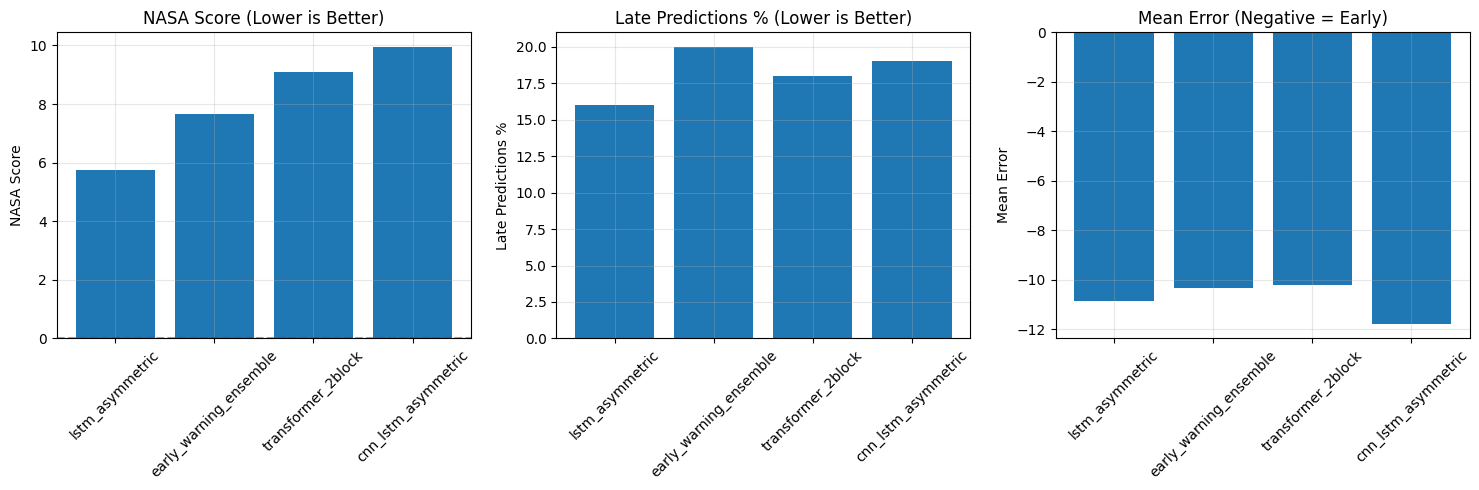


📊 PREDICTION ERROR ANALYSIS - FD001
   Best Model: lstm_asymmetric
   Total predictions: 100
   Late predictions (dangerous): 22 (22.0%)
   Early predictions (safe): 78 (78.0%)
   Accurate predictions (±5 cycles): 25 (25.0%)
   Mean late error: 9.94 cycles
   Mean early error: 16.75 cycles


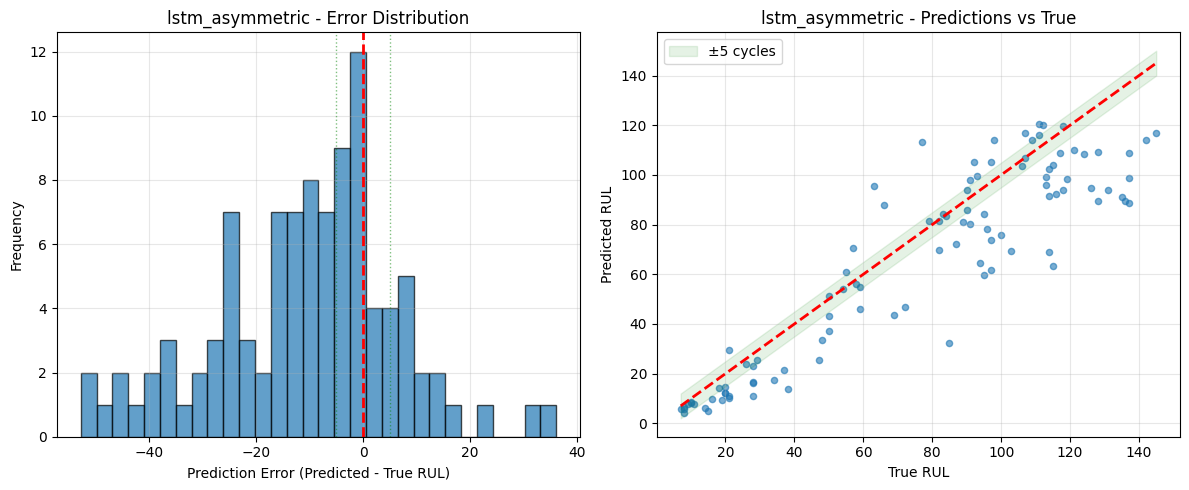


💾 STEP 8: Saving best model...
✅ Best model saved to /content/models/best_model_early_warning_FD001.h5

🚀 STEP 9: Creating deployment package...
📦 Creating deployment package...


✅ Deployment package created in /content/deployment_FD001
  adding: deployment_FD001/ (stored 0%)
  adding: deployment_FD001/model_summary.txt (deflated 87%)
  adding: deployment_FD001/feature_columns.csv (deflated 74%)
  adding: deployment_FD001/predictor.py (deflated 64%)
  adding: deployment_FD001/requirements.txt (deflated 14%)
  adding: deployment_FD001/scaler.pkl (deflated 31%)
📦 Zip file created: /content/deployment_package_FD001.zip

✅ OPTIMIZED WORKFLOW COMPLETE FOR FD001
✅ FD001 analysis complete

🔍 Processing FD002...

🚀 OPTIMIZED PREDICTIVE MAINTENANCE WORKFLOW
🎯 Focus: EARLY FAILURE DETECTION
📊 DATASET: FD002

📥 STEP 1: Loading data...

📥 Loading dataset FD002...
   Loaded train_FD002.txt: 53759 rows, 26 columns
   Loaded test_FD002.txt: 33991 rows, 26 columns
   Loaded RUL_FD002.txt: 259 rows, 1 columns

🔍 STEP 2: Data exploration...

📊 INTERACTIVE EXPLORATION - FD002



📈 DATASET STATISTICS:
   Total engines: 260
   Total cycles: 53759
   Average cycles per engine: 206.8

🔗 Feature correlations (top 10 sensors):


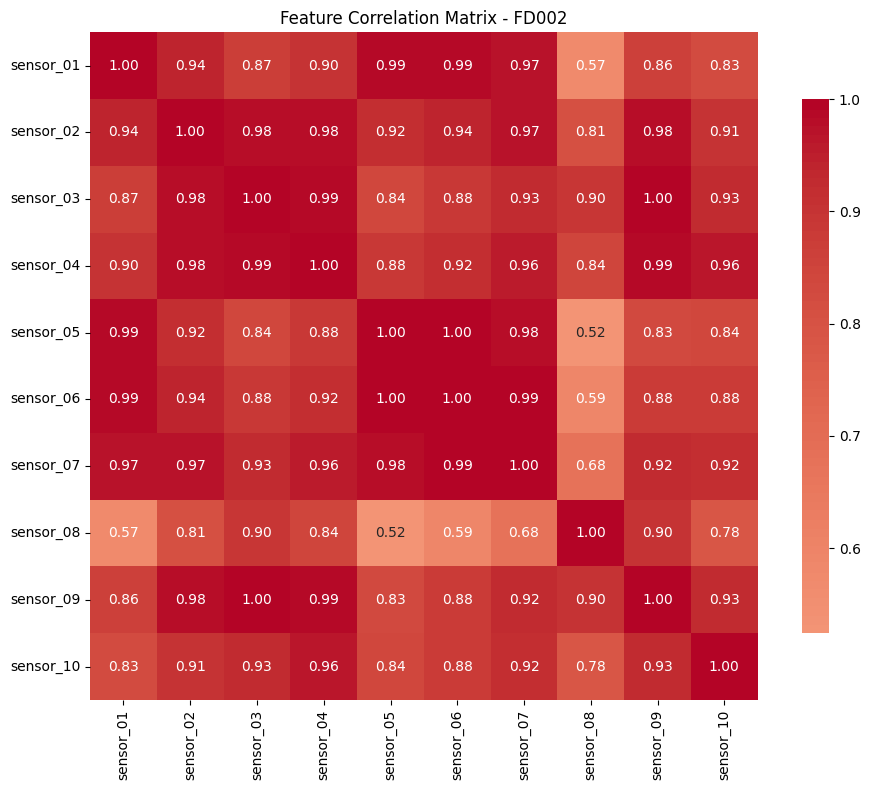


⚙️ STEP 3: Optimized data processing...
🧹 Cleaning data (NASA C-MAPSS style) for FD002...
   Removed 6 noisy sensors: ['sensor_01', 'sensor_05', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
   Using 15 sensor columns
   Calculating training RUL with early warning...
   RUL range: 0.0 to 150.0
🔧 Engineering optimized features (window=15)...
   Using 14 critical sensors
   Total optimized features: 54
📊 Normalizing data...
   Normalized 50 features

🔄 STEP 4: Preparing sequences with engine IDs...
🔄 Creating sequences with engine IDs (length=50)...
   Training: (40759, 50, 50) sequences from 260 engines
   Test: (259, 50, 50) sequences from 259 engines

🎯 STEP 5: Training with engine-based validation...
🛡️ Creating validation split by ENGINE ID (no data leakage)...
   Training engines: 208
   Validation engines: 52
   Training sequences: (33064, 50, 50)
   Validation sequences: (7695, 50, 50)

🔨 STEP 6: Training early-warning models...
🔨 Training early-warning optimized models...

517/517 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - early_warning_accuracy: 0.8158 - early_warning_loss: 0.3835 - loss: 4644.5059 - rul_prediction_loss: 4644.3877 - rul_prediction_mae: 51.4841 - rul_prediction_mse: 4414.1499 - val_early_warning_accuracy: 0.9077 - val_early_warning_loss: 0.2224 - val_loss: 1382.5884 - val_rul_prediction_loss: 1375.0015 - val_rul_prediction_mae: 22.1979 - val_rul_prediction_mse: 876.8874 - learning_rate: 0.0010
Epoch 2/100
512/517 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - early_warning_accuracy: 0.8951 - early_warning_loss: 0.2373 - loss: 1604.2280 - rul_prediction_loss: 1604.1575 - rul_prediction_mae: 26.1210 - rul_prediction_mse: 1171.1471
Epoch 2: val_loss did not improve from 1382.58838
517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - early_warning_accuracy: 0.8951 - early_warning_loss: 0.2371 - loss: 1603.0786 - rul_prediction_loss: 1603.0089 - rul_prediction_mae: 26.1105 - rul_prediction_mse: 1170.2776 - val_early_warning_accuracy: 0.9089 - val_early_warning_loss: 0.2

517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - early_warning_accuracy: 0.9425 - early_warning_loss: 0.1313 - loss: 689.2749 - rul_prediction_loss: 689.2355 - rul_prediction_mae: 16.6283 - rul_prediction_mse: 489.8788 - val_early_warning_accuracy: 0.9392 - val_early_warning_loss: 0.1533 - val_loss: 1259.2607 - val_rul_prediction_loss: 1252.7576 - val_rul_prediction_mae: 20.6323 - val_rul_prediction_mse: 816.0975 - learning_rate: 0.0010
Epoch 10/100
513/517 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - early_warning_accuracy: 0.9460 - early_warning_loss: 0.1253 - loss: 648.8233 - rul_prediction_loss: 648.7855 - rul_prediction_mae: 16.0198 - rul_prediction_mse: 452.3181
Epoch 10: val_loss did not improve from 1259.26074
517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - early_warning_accuracy: 0.9460 - early_warning_loss: 0.1253 - loss: 648.8659 - rul_prediction_loss: 648.8282 - rul_prediction_mae: 16.0200 - rul_prediction_mse: 452.3296 - val_early_warning_accuracy: 0.9277 - val_early_warning_loss: 0.1867 - val

517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - early_warning_accuracy: 0.9541 - early_warning_loss: 0.1071 - loss: 462.1304 - rul_prediction_loss: 462.0985 - rul_prediction_mae: 13.6634 - rul_prediction_mse: 323.6461 - val_early_warning_accuracy: 0.9300 - val_early_warning_loss: 0.1626 - val_loss: 1150.6157 - val_rul_prediction_loss: 1152.2653 - val_rul_prediction_mae: 19.7748 - val_rul_prediction_mse: 739.1482 - learning_rate: 0.0010
Epoch 18/100
515/517 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - early_warning_accuracy: 0.9535 - early_warning_loss: 0.1064 - loss: 450.1474 - rul_prediction_loss: 450.1153 - rul_prediction_mae: 13.4990 - rul_prediction_mse: 317.3030
Epoch 18: val_loss did not improve from 1150.61572
517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - early_warning_accuracy: 0.9535 - early_warning_loss: 0.1064 - loss: 450.1939 - rul_prediction_loss: 450.1618 - rul_prediction_mae: 13.4986 - rul_prediction_mse: 317.2807 - val_early_warning_accuracy: 0.9426 - val_early_warning_loss: 0.1498 - val

517/517 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 7716.7100 - rul_loss: 7716.5234 - rul_mae: 78.1040 - rul_mse: 7716.5264 - warning_accuracy: 0.8041 - warning_loss: 0.3635 - val_loss: 3211.0159 - val_rul_loss: 3205.1155 - val_rul_mae: 51.1889 - val_rul_mse: 3200.5503 - val_warning_accuracy: 0.9172 - val_warning_loss: 0.2227 - learning_rate: 0.0010
Epoch 2/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3541.3083 - rul_loss: 3541.2256 - rul_mae: 55.5322 - rul_mse: 3539.6423 - warning_accuracy: 0.9276 - warning_loss: 0.1687
Epoch 2: val_loss improved from 3211.01587 to 1570.08008, saving model to /content/models/early_warning_ensemble_best.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 3537.8579 - rul_loss: 3537.7698 - rul_mae: 55.4995 - rul_mse: 3536.1846 - warning_accuracy: 0.9277 - warning_loss: 0.1687 - val_loss: 1570.0801 - val_rul_loss: 1561.5533 - val_rul_mae: 28.6842 - val_rul_mse: 1305.9960 - val_warning_accuracy: 0.9310 - val_warning_loss: 0.1928 - learning_rate: 0.0010
Epoch 3/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 893.4687 - rul_loss: 893.3987 - rul_mae: 24.6789 - rul_mse: 853.0892 - warning_accuracy: 0.9397 - warning_loss: 0.1401
Epoch 3: val_loss improved from 1570.08008 to 1479.30957, saving model to /content/models/early_warning_ensemble_best.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 892.7640 - rul_loss: 892.6929 - rul_mae: 24.6628 - rul_mse: 852.2515 - warning_accuracy: 0.9397 - warning_loss: 0.1401 - val_loss: 1479.3096 - val_rul_loss: 1474.7184 - val_rul_mae: 22.1121 - val_rul_mse: 885.4827 - val_warning_accuracy: 0.9122 - val_warning_loss: 0.2342 - learning_rate: 0.0010
Epoch 4/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 467.7121 - rul_loss: 467.6542 - rul_mae: 14.8001 - rul_mse: 357.1076 - warning_accuracy: 0.9516 - warning_loss: 0.1161
Epoch 4: val_loss did not improve from 1479.30957
517/517 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 467.6364 - rul_loss: 467.5781 - rul_mae: 14.7985 - rul_mse: 357.0277 - warning_accuracy: 0.9516 - warning_loss: 0.1161 - val_loss: 1599.6802 - val_rul_loss: 1599.9233 - val_rul_mae: 20.8602 - val_rul_mse: 817.8932 - val_warning_accuracy: 0.9240 - val_warning_loss: 0.2256 - learning_rate: 0.0010
Epoch 5/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 381.0366 - ru

517/517 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 4959.0273 - mae: 52.7273 - mse: 4281.9551 - val_loss: 1652.3995 - val_mae: 24.8493 - val_mse: 1037.7200 - learning_rate: 0.0010
Epoch 2/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2192.4641 - mae: 31.5295 - mse: 1635.4645
Epoch 2: val_loss improved from 1652.39954 to 1339.17957, saving model to /content/models/lstm_asymmetric_best.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 2191.9026 - mae: 31.5249 - mse: 1635.0741 - val_loss: 1339.1796 - val_mae: 20.6270 - val_mse: 760.3807 - learning_rate: 0.0010
Epoch 3/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1548.1442 - mae: 25.9971 - mse: 1146.1094
Epoch 3: val_loss improved from 1339.17957 to 1222.97302, saving model to /content/models/lstm_asymmetric_best.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 1547.9629 - mae: 25.9953 - mse: 1145.9694 - val_loss: 1222.9730 - val_mae: 19.4788 - val_mse: 656.7473 - learning_rate: 0.0010
Epoch 4/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1375.2074 - mae: 24.2740 - mse: 1015.7460
Epoch 4: val_loss did not improve from 1222.97302
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1375.0695 - mae: 24.2725 - mse: 1015.6370 - val_loss: 1297.3849 - val_mae: 18.6823 - val_mse: 623.5925 - learning_rate: 0.0010
Epoch 5/100
515/517 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1217.5778 - mae: 22.6205 - mse: 895.1010
Epoch 5: val_loss did not improve from 1222.97302
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 1217.3237 - mae: 22.6182 - mse: 894.9235 - val_loss: 1740.2791 - val_mae: 19.5965 - val_mse: 675.6031 - learning_rate: 0.0010
Epoch 6/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 935.6237 - mae: 19.6866 - mse: 689.6569
Epoch 6: val_loss did not improve from 1222.97302
517/517 

517/517 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 3930.8264 - mae: 46.4550 - mse: 3654.1692 - val_loss: 1640.7518 - val_mae: 22.6929 - val_mse: 906.0635 - learning_rate: 0.0010
Epoch 2/100
515/517 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1600.9094 - mae: 26.6061 - mse: 1196.3899
Epoch 2: val_loss did not improve from 1640.75183
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1600.2186 - mae: 26.5997 - mse: 1195.8881 - val_loss: 1873.3164 - val_mae: 20.3378 - val_mse: 696.6262 - learning_rate: 0.0010
Epoch 3/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1176.8660 - mae: 22.5639 - mse: 873.9722
Epoch 3: val_loss did not improve from 1640.75183
517/517 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 1176.7771 - mae: 22.5630 - mse: 873.9041 - val_loss: 1839.2780 - val_mae: 21.8109 - val_mse: 820.0225 - learning_rate: 0.0010
Epoch 4/100
514/517 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 954.1777 - mae: 20.0452 - mse: 693.9178
Epoch 4: val_loss did not improve from 1640.75183
517/517 

517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 663.7569 - mae: 16.6827 - mse: 478.8837 - val_loss: 1471.4587 - val_mae: 24.8697 - val_mse: 1119.6322 - learning_rate: 0.0010
Epoch 7/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 566.9327 - mae: 15.4345 - mse: 409.6548
Epoch 7: val_loss improved from 1471.45874 to 1451.67090, saving model to /content/models/cnn_lstm_asymmetric_best.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 566.9153 - mae: 15.4342 - mse: 409.6364 - val_loss: 1451.6709 - val_mae: 23.3896 - val_mse: 1013.8491 - learning_rate: 0.0010
Epoch 8/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 508.1443 - mae: 14.5747 - mse: 363.7791
Epoch 8: val_loss improved from 1451.67090 to 1424.72290, saving model to /content/models/cnn_lstm_asymmetric_best.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 508.1176 - mae: 14.5742 - mse: 363.7545 - val_loss: 1424.7229 - val_mae: 21.5740 - val_mse: 867.8453 - learning_rate: 0.0010
Epoch 9/100
515/517 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 451.5552 - mae: 13.6770 - mse: 318.2789
Epoch 9: val_loss did not improve from 1424.72290
517/517 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 451.5503 - mae: 13.6766 - mse: 318.2701 - val_loss: 1816.9674 - val_mae: 20.8478 - val_mse: 862.4202 - learning_rate: 0.0010
Epoch 10/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 413.4183 - mae: 13.0132 - mse: 291.1086
Epoch 10: val_loss did not improve from 1424.72290
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 413.3999 - mae: 13.0130 - mse: 291.0992 - val_loss: 1729.7874 - val_mae: 21.5227 - val_mse: 861.8563 - learning_rate: 0.0010
Epoch 11/100
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 377.5841 - mae: 12.4599 - mse: 267.2196
Epoch 11: val_loss did not improve from 1424.72290
517/517 ━━━━━━

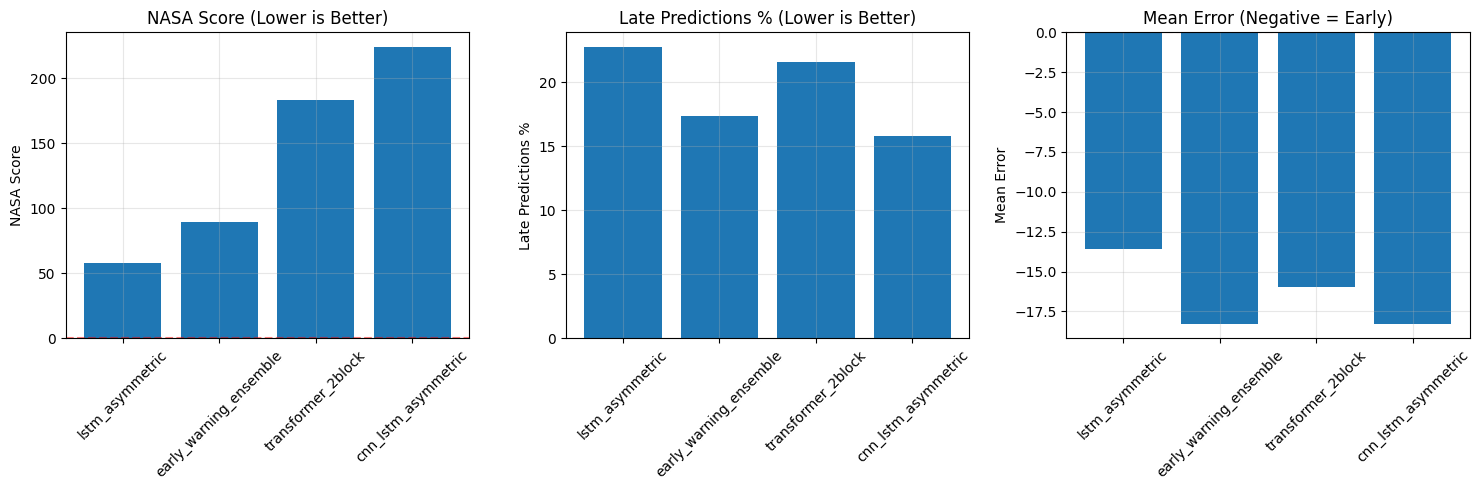


📊 PREDICTION ERROR ANALYSIS - FD002
   Best Model: lstm_asymmetric
   Total predictions: 259
   Late predictions (dangerous): 82 (31.7%)
   Early predictions (safe): 177 (68.3%)
   Accurate predictions (±5 cycles): 55 (21.2%)
   Mean late error: 14.99 cycles
   Mean early error: 26.81 cycles


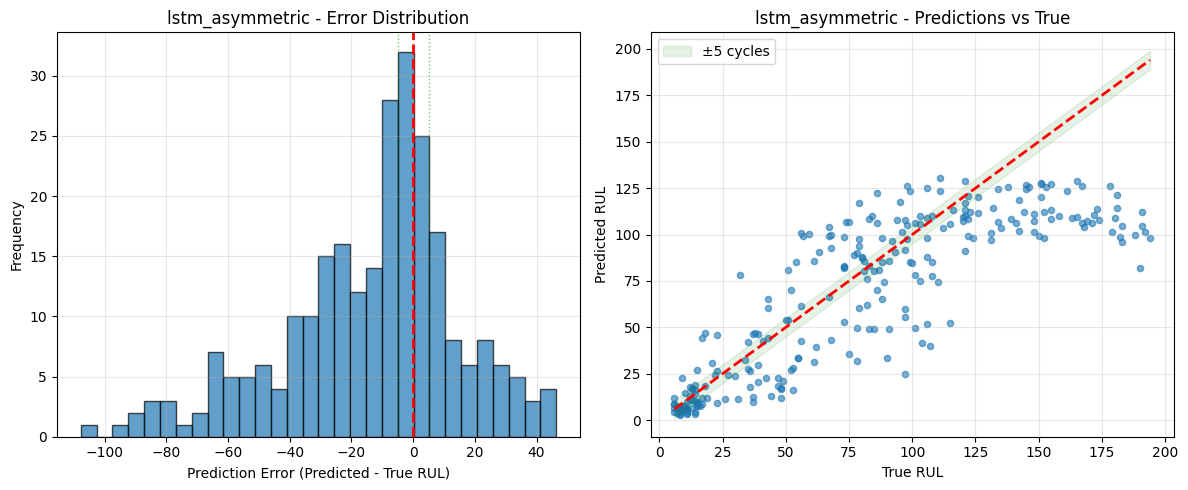


💾 STEP 8: Saving best model...
✅ Best model saved to /content/models/best_model_early_warning_FD002.h5

🚀 STEP 9: Creating deployment package...
📦 Creating deployment package...


✅ Deployment package created in /content/deployment_FD002
updating: deployment_FD002/ (stored 0%)
updating: deployment_FD002/model_summary.txt (deflated 87%)
updating: deployment_FD002/feature_columns.csv (deflated 74%)
updating: deployment_FD002/predictor.py (deflated 64%)
updating: deployment_FD002/requirements.txt (deflated 14%)
updating: deployment_FD002/scaler.pkl (deflated 31%)
📦 Zip file created: /content/deployment_package_FD002.zip

✅ OPTIMIZED WORKFLOW COMPLETE FOR FD002
✅ FD002 analysis complete

🔍 Processing FD003...

🚀 OPTIMIZED PREDICTIVE MAINTENANCE WORKFLOW
🎯 Focus: EARLY FAILURE DETECTION
📊 DATASET: FD003

📥 STEP 1: Loading data...

📥 Loading dataset FD003...
   Loaded train_FD003.txt: 24720 rows, 26 columns
   Loaded test_FD003.txt: 16596 rows, 26 columns
   Loaded RUL_FD003.txt: 100 rows, 1 columns

🔍 STEP 2: Data exploration...

📊 INTERACTIVE EXPLORATION - FD003



📈 DATASET STATISTICS:
   Total engines: 100
   Total cycles: 24720
   Average cycles per engine: 247.2

🔗 Feature correlations (top 10 sensors):


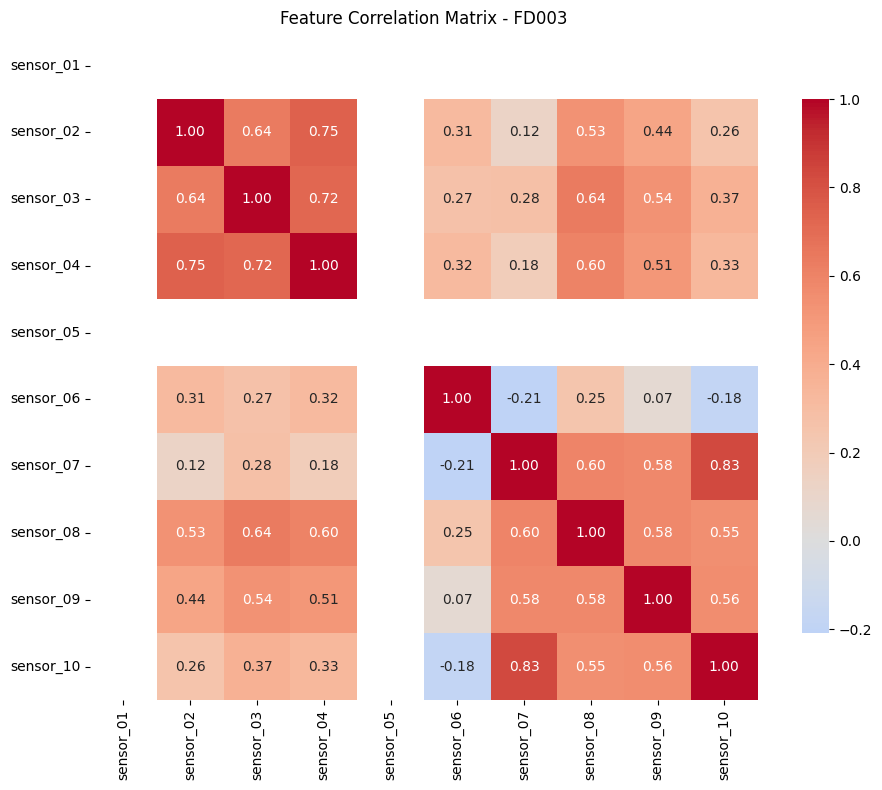


⚙️ STEP 3: Optimized data processing...
🧹 Cleaning data (NASA C-MAPSS style) for FD003...
   Removed 6 noisy sensors: ['sensor_01', 'sensor_05', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
   Using 15 sensor columns
   Calculating training RUL with early warning...
   RUL range: 0.0 to 150.0
🔧 Engineering optimized features (window=15)...
   Using 14 critical sensors
   Total optimized features: 54
📊 Normalizing data...
   Normalized 50 features

🔄 STEP 4: Preparing sequences with engine IDs...
🔄 Creating sequences with engine IDs (length=50)...
   Training: (19720, 50, 50) sequences from 100 engines
   Test: (100, 50, 50) sequences from 100 engines

🎯 STEP 5: Training with engine-based validation...
🛡️ Creating validation split by ENGINE ID (no data leakage)...
   Training engines: 80
   Validation engines: 20
   Training sequences: (16012, 50, 50)
   Validation sequences: (3708, 50, 50)

🔨 STEP 6: Training early-warning models...
🔨 Training early-warning optimized models...


251/251 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - early_warning_accuracy: 0.8452 - early_warning_loss: 0.3406 - loss: 8056.0957 - rul_prediction_loss: 8056.0000 - rul_prediction_mae: 74.9454 - rul_prediction_mse: 7999.7515 - val_early_warning_accuracy: 0.9013 - val_early_warning_loss: 0.1794 - val_loss: 1456.9469 - val_rul_prediction_loss: 1456.4548 - val_rul_prediction_mae: 30.0522 - val_rul_prediction_mse: 1386.5996 - learning_rate: 0.0010
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - early_warning_accuracy: 0.9462 - early_warning_loss: 0.1264 - loss: 1161.5815 - rul_prediction_loss: 1161.5586 - rul_prediction_mae: 22.1776 - rul_prediction_mse: 840.9383
Epoch 2: val_loss improved from 1456.94690 to 1104.72583, saving model to /content/models/transformer_2block_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - early_warning_accuracy: 0.9462 - early_warning_loss: 0.1264 - loss: 1160.7507 - rul_prediction_loss: 1160.7426 - rul_prediction_mae: 22.1691 - rul_prediction_mse: 840.3196 - val_early_warning_accuracy: 0.9655 - val_early_warning_loss: 0.0863 - val_loss: 1104.7258 - val_rul_prediction_loss: 1104.6740 - val_rul_prediction_mae: 14.3765 - val_rul_prediction_mse: 375.5632 - learning_rate: 0.0010
Epoch 3/100
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - early_warning_accuracy: 0.9588 - early_warning_loss: 0.0931 - loss: 775.0529 - rul_prediction_loss: 775.0249 - rul_prediction_mae: 17.9665 - rul_prediction_mse: 534.7021
Epoch 3: val_loss improved from 1104.72583 to 1051.69446, saving model to /content/models/transformer_2block_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - early_warning_accuracy: 0.9589 - early_warning_loss: 0.0930 - loss: 774.5939 - rul_prediction_loss: 774.5877 - rul_prediction_mae: 17.9598 - rul_prediction_mse: 534.3138 - val_early_warning_accuracy: 0.9684 - val_early_warning_loss: 0.0714 - val_loss: 1051.6945 - val_rul_prediction_loss: 1051.0873 - val_rul_prediction_mae: 13.6358 - val_rul_prediction_mse: 361.6428 - learning_rate: 0.0010
Epoch 4/100
245/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - early_warning_accuracy: 0.9681 - early_warning_loss: 0.0750 - loss: 623.7267 - rul_prediction_loss: 623.7042 - rul_prediction_mae: 15.6601 - rul_prediction_mse: 416.3732
Epoch 4: val_loss did not improve from 1051.69446
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - early_warning_accuracy: 0.9682 - early_warning_loss: 0.0749 - loss: 623.8248 - rul_prediction_loss: 623.8007 - rul_prediction_mae: 15.6633 - rul_prediction_mse: 416.4984 - val_early_warning_accuracy: 0.9399 - val_early_warning_loss: 0.1599 - val_l

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - early_warning_accuracy: 0.9672 - early_warning_loss: 0.0773 - loss: 584.0176 - rul_prediction_loss: 583.9910 - rul_prediction_mae: 15.5191 - rul_prediction_mse: 399.1861 - val_early_warning_accuracy: 0.9614 - val_early_warning_loss: 0.0965 - val_loss: 979.8819 - val_rul_prediction_loss: 979.7961 - val_rul_prediction_mae: 13.3229 - val_rul_prediction_mse: 317.2101 - learning_rate: 0.0010
Epoch 6/100
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - early_warning_accuracy: 0.9748 - early_warning_loss: 0.0633 - loss: 522.0341 - rul_prediction_loss: 522.0152 - rul_prediction_mae: 14.5998 - rul_prediction_mse: 366.5262
Epoch 6: val_loss improved from 979.88190 to 670.10748, saving model to /content/models/transformer_2block_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - early_warning_accuracy: 0.9748 - early_warning_loss: 0.0632 - loss: 521.6251 - rul_prediction_loss: 521.6493 - rul_prediction_mae: 14.5909 - rul_prediction_mse: 366.0753 - val_early_warning_accuracy: 0.9701 - val_early_warning_loss: 0.0678 - val_loss: 670.1075 - val_rul_prediction_loss: 669.5829 - val_rul_prediction_mae: 13.4785 - val_rul_prediction_mse: 334.0562 - learning_rate: 0.0010
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - early_warning_accuracy: 0.9766 - early_warning_loss: 0.0578 - loss: 463.6743 - rul_prediction_loss: 463.6585 - rul_prediction_mae: 13.7042 - rul_prediction_mse: 315.9055
Epoch 7: val_loss did not improve from 670.10748
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - early_warning_accuracy: 0.9766 - early_warning_loss: 0.0578 - loss: 463.6203 - rul_prediction_loss: 463.6060 - rul_prediction_mae: 13.7030 - rul_prediction_mse: 315.8584 - val_early_warning_accuracy: 0.9714 - val_early_warning_loss: 0.0622 - val_lo

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - early_warning_accuracy: 0.9873 - early_warning_loss: 0.0305 - loss: 268.6751 - rul_prediction_loss: 268.6776 - rul_prediction_mae: 10.3113 - rul_prediction_mse: 179.7474 - val_early_warning_accuracy: 0.9730 - val_early_warning_loss: 0.0694 - val_loss: 627.5110 - val_rul_prediction_loss: 627.0725 - val_rul_prediction_mae: 12.6292 - val_rul_prediction_mse: 286.1820 - learning_rate: 5.0000e-04
Epoch 19/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - early_warning_accuracy: 0.9883 - early_warning_loss: 0.0273 - loss: 252.2486 - rul_prediction_loss: 252.2396 - rul_prediction_mae: 10.0923 - rul_prediction_mse: 174.1006
Epoch 19: val_loss did not improve from 627.51099
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - early_warning_accuracy: 0.9883 - early_warning_loss: 0.0273 - loss: 252.2373 - rul_prediction_loss: 252.2277 - rul_prediction_mae: 10.0923 - rul_prediction_mse: 174.0992 - val_early_warning_accuracy: 0.9622 - val_early_warning_loss: 0.1177 - v

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - early_warning_accuracy: 0.9884 - early_warning_loss: 0.0287 - loss: 238.4596 - rul_prediction_loss: 238.4509 - rul_prediction_mae: 9.8014 - rul_prediction_mse: 167.7587 - val_early_warning_accuracy: 0.9684 - val_early_warning_loss: 0.0730 - val_loss: 605.0817 - val_rul_prediction_loss: 604.5518 - val_rul_prediction_mae: 14.3182 - val_rul_prediction_mse: 339.9556 - learning_rate: 5.0000e-04
Epoch 25/100
244/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - early_warning_accuracy: 0.9913 - early_warning_loss: 0.0227 - loss: 245.2245 - rul_prediction_loss: 245.2177 - rul_prediction_mae: 10.0050 - rul_prediction_mse: 170.4472
Epoch 25: val_loss did not improve from 605.08173
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - early_warning_accuracy: 0.9913 - early_warning_loss: 0.0228 - loss: 245.1832 - rul_prediction_loss: 245.1792 - rul_prediction_mae: 10.0004 - rul_prediction_mse: 170.3375 - val_early_warning_accuracy: 0.9746 - val_early_warning_loss: 0.0580 - val

251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 10812.3613 - rul_loss: 10812.0498 - rul_mae: 93.6928 - rul_mse: 10812.0791 - warning_accuracy: 0.6365 - warning_loss: 0.5612 - val_loss: 8481.8125 - val_rul_loss: 8474.6807 - val_rul_mae: 86.5024 - val_rul_mse: 8481.6895 - val_warning_accuracy: 0.8533 - val_warning_loss: 0.2473 - learning_rate: 0.0010
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8604.5459 - rul_loss: 8604.3848 - rul_mae: 87.5700 - rul_mse: 8604.4395 - warning_accuracy: 0.9156 - warning_loss: 0.2153
Epoch 2: val_loss improved from 8481.81250 to 6012.94922, saving model to /content/models/early_warning_ensemble_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 8601.3496 - rul_loss: 8601.1338 - rul_mae: 87.5561 - rul_mse: 8601.2432 - warning_accuracy: 0.9156 - warning_loss: 0.2152 - val_loss: 6012.9492 - val_rul_loss: 6009.2720 - val_rul_mae: 75.2223 - val_rul_mse: 6012.8765 - val_warning_accuracy: 0.9213 - val_warning_loss: 0.1478 - learning_rate: 0.0010
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5666.1104 - rul_loss: 5666.0576 - rul_mae: 73.5740 - rul_mse: 5666.0459 - warning_accuracy: 0.9451 - warning_loss: 0.1247
Epoch 3: val_loss improved from 6012.94922 to 3840.10132, saving model to /content/models/early_warning_ensemble_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 5663.4551 - rul_loss: 5663.4146 - rul_mae: 73.5569 - rul_mse: 5663.3906 - warning_accuracy: 0.9451 - warning_loss: 0.1247 - val_loss: 3840.1013 - val_rul_loss: 3839.1689 - val_rul_mae: 59.7253 - val_rul_mse: 3838.0469 - val_warning_accuracy: 0.9407 - val_warning_loss: 0.1122 - learning_rate: 0.0010
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3328.4644 - rul_loss: 3328.4087 - rul_mae: 56.5314 - rul_mse: 3328.4111 - warning_accuracy: 0.9547 - warning_loss: 0.1070
Epoch 4: val_loss improved from 3840.10132 to 1948.69702, saving model to /content/models/early_warning_ensemble_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 3326.2861 - rul_loss: 3326.2278 - rul_mae: 56.5104 - rul_mse: 3326.2329 - warning_accuracy: 0.9547 - warning_loss: 0.1070 - val_loss: 1948.6970 - val_rul_loss: 1947.8812 - val_rul_mae: 41.1411 - val_rul_mse: 1928.0374 - val_warning_accuracy: 0.9738 - val_warning_loss: 0.0659 - learning_rate: 0.0010
Epoch 5/100
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1564.6515 - rul_loss: 1564.6061 - rul_mae: 37.6028 - rul_mse: 1564.4958 - warning_accuracy: 0.9614 - warning_loss: 0.0905
Epoch 5: val_loss improved from 1948.69702 to 920.12604, saving model to /content/models/early_warning_ensemble_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 1562.2653 - rul_loss: 1562.2274 - rul_mae: 37.5679 - rul_mse: 1562.1072 - warning_accuracy: 0.9614 - warning_loss: 0.0905 - val_loss: 920.1260 - val_rul_loss: 919.5541 - val_rul_mae: 25.9968 - val_rul_mse: 856.1776 - val_warning_accuracy: 0.9771 - val_warning_loss: 0.0537 - learning_rate: 0.0010
Epoch 6/100
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 656.5451 - rul_loss: 656.5021 - rul_mae: 22.0513 - rul_mse: 642.7144 - warning_accuracy: 0.9635 - warning_loss: 0.0859
Epoch 6: val_loss improved from 920.12604 to 630.69794, saving model to /content/models/early_warning_ensemble_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 655.6799 - rul_loss: 655.6362 - rul_mae: 22.0296 - rul_mse: 641.7784 - warning_accuracy: 0.9635 - warning_loss: 0.0859 - val_loss: 630.6979 - val_rul_loss: 630.0853 - val_rul_mae: 16.6902 - val_rul_mse: 424.0302 - val_warning_accuracy: 0.9760 - val_warning_loss: 0.0589 - learning_rate: 0.0010
Epoch 7/100
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 347.0179 - rul_loss: 346.9824 - rul_mae: 14.0235 - rul_mse: 300.3154 - warning_accuracy: 0.9712 - warning_loss: 0.0711
Epoch 7: val_loss did not improve from 630.69794
251/251 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 346.9667 - rul_loss: 346.9482 - rul_mae: 14.0186 - rul_mse: 300.1670 - warning_accuracy: 0.9712 - warning_loss: 0.0711 - val_loss: 652.6951 - val_rul_loss: 651.9744 - val_rul_mae: 14.6215 - val_rul_mse: 360.3069 - val_warning_accuracy: 0.9711 - val_warning_loss: 0.0666 - learning_rate: 0.0010
Epoch 8/100
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 318.9319 - rul_loss:

251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 4979.2603 - mae: 51.9830 - mse: 4832.7993 - val_loss: 696.0630 - val_mae: 16.7542 - val_mse: 512.0472 - learning_rate: 0.0010
Epoch 2/100
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 511.6095 - mae: 14.2791 - mse: 359.6170
Epoch 2: val_loss improved from 696.06299 to 559.78455, saving model to /content/models/lstm_asymmetric_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 510.7125 - mae: 14.2644 - mse: 358.9418 - val_loss: 559.7845 - val_mae: 14.2619 - val_mse: 402.2087 - learning_rate: 0.0010
Epoch 3/100
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 279.7052 - mae: 10.5977 - mse: 198.8340
Epoch 3: val_loss did not improve from 559.78455
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 279.2957 - mae: 10.5904 - mse: 198.5174 - val_loss: 634.2447 - val_mae: 11.5738 - val_mse: 278.2120 - learning_rate: 0.0010
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 177.4026 - mae: 8.6419 - mse: 126.2665
Epoch 4: val_loss did not improve from 559.78455
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 177.3655 - mae: 8.6410 - mse: 126.2384 - val_loss: 855.5843 - val_mae: 12.4499 - val_mse: 315.6157 - learning_rate: 0.0010
Epoch 5/100
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 165.3619 - mae: 8.3081 - mse: 117.1276
Epoch 5: val_loss did not improve from 559.78455
251/251 ━━━━━━━━━━━━━━━━━━━

251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 7061.1021 - mae: 68.8782 - mse: 7002.7417 - val_loss: 2223.8743 - val_mae: 18.2670 - val_mse: 622.7545 - learning_rate: 0.0010
Epoch 2/100
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1099.2188 - mae: 21.8357 - mse: 831.5707
Epoch 2: val_loss did not improve from 2223.87427
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1100.9238 - mae: 21.8537 - mse: 833.0931 - val_loss: 3034.9629 - val_mae: 26.9564 - val_mse: 988.4023 - learning_rate: 0.0010
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1499.5339 - mae: 24.6956 - mse: 999.6211 
Epoch 3: val_loss improved from 2223.87427 to 1032.07703, saving model to /content/models/cnn_lstm_asymmetric_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1498.4491 - mae: 24.6898 - mse: 999.2571 - val_loss: 1032.0770 - val_mae: 20.9152 - val_mse: 744.8403 - learning_rate: 0.0010
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 932.4441 - mae: 20.3874 - mse: 689.0916
Epoch 4: val_loss did not improve from 1032.07703
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 932.3235 - mae: 20.3848 - mse: 688.9481 - val_loss: 1539.2642 - val_mae: 15.1359 - val_mse: 437.2725 - learning_rate: 0.0010
Epoch 5/100
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 819.4910 - mae: 18.6709 - mse: 573.0457
Epoch 5: val_loss did not improve from 1032.07703
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 819.3496 - mae: 18.6724 - mse: 573.2627 - val_loss: 2236.9485 - val_mae: 19.7290 - val_mse: 668.7358 - learning_rate: 0.0010
Epoch 6/100
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 823.3832 - mae: 19.0776 - mse: 614.3545
Epoch 6: val_loss improved from 1032.07703 to 752.46246, saving mode

251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 823.0071 - mae: 19.0716 - mse: 613.9599 - val_loss: 752.4625 - val_mae: 16.6087 - val_mse: 500.4784 - learning_rate: 0.0010
Epoch 7/100
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 646.8545 - mae: 16.7319 - mse: 468.5570
Epoch 7: val_loss did not improve from 752.46246
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 646.4311 - mae: 16.7255 - mse: 468.1835 - val_loss: 779.2206 - val_mae: 15.8903 - val_mse: 414.1998 - learning_rate: 0.0010
Epoch 8/100
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 576.5466 - mae: 15.8721 - mse: 417.9170
Epoch 8: val_loss did not improve from 752.46246
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 576.4854 - mae: 15.8704 - mse: 417.8239 - val_loss: 979.6765 - val_mae: 19.8068 - val_mse: 603.3015 - learning_rate: 0.0010
Epoch 9/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 564.8759 - mae: 15.9911 - mse: 425.0249
Epoch 9: val_loss did not improve from 752.46246
251/251 ━━━━━━━━━━━━━━━━━

251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 476.2132 - mae: 14.2779 - mse: 340.8868 - val_loss: 706.5595 - val_mae: 15.8718 - val_mse: 466.7725 - learning_rate: 0.0010
Epoch 12/100
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 426.1714 - mae: 13.6043 - mse: 309.9809
Epoch 12: val_loss did not improve from 706.55951
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 426.1938 - mae: 13.6037 - mse: 309.9262 - val_loss: 852.1579 - val_mae: 17.2904 - val_mse: 505.4558 - learning_rate: 0.0010
Epoch 13/100
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 391.1920 - mae: 13.0857 - mse: 282.8232
Epoch 13: val_loss did not improve from 706.55951
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 391.2576 - mae: 13.0863 - mse: 282.8462 - val_loss: 1090.5596 - val_mae: 14.9914 - val_mse: 425.9882 - learning_rate: 0.0010
Epoch 14/100
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 358.7263 - mae: 12.3651 - mse: 249.7046
Epoch 14: val_loss did not improve from 706.55951
251/251 ━━━━━━━━━

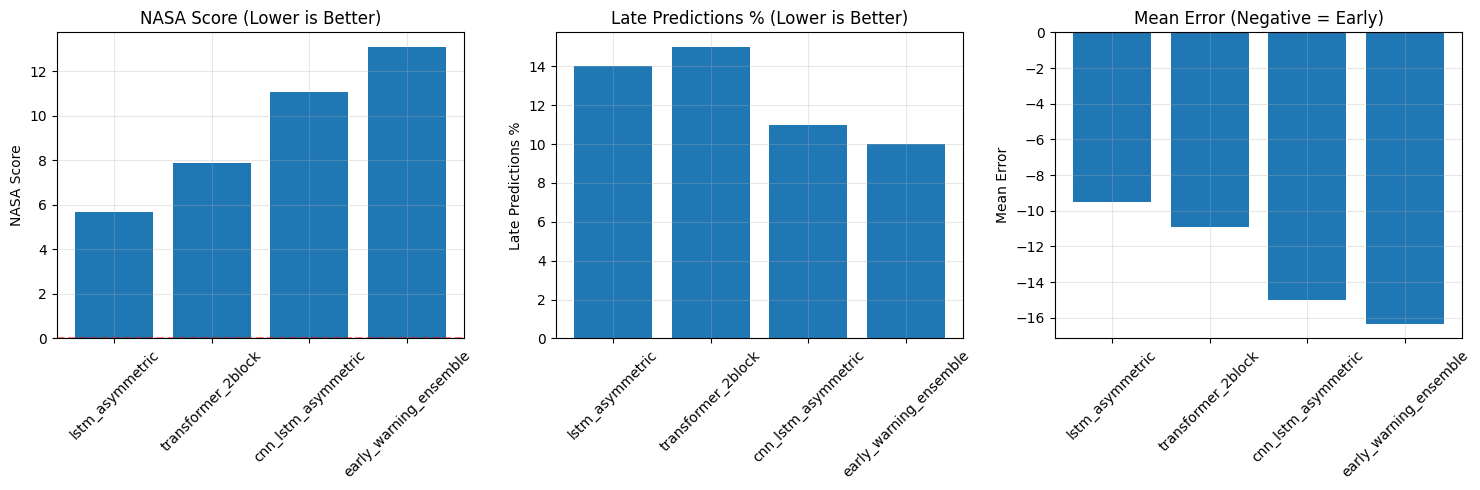


📊 PREDICTION ERROR ANALYSIS - FD003
   Best Model: lstm_asymmetric
   Total predictions: 100
   Late predictions (dangerous): 24 (24.0%)
   Early predictions (safe): 76 (76.0%)
   Accurate predictions (±5 cycles): 23 (23.0%)
   Mean late error: 10.21 cycles
   Mean early error: 15.77 cycles


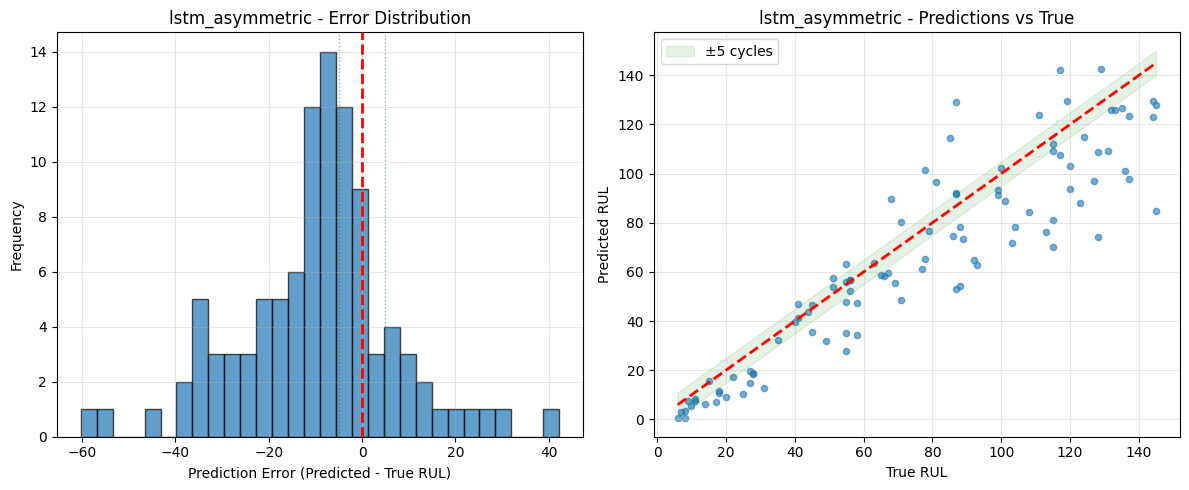


💾 STEP 8: Saving best model...
✅ Best model saved to /content/models/best_model_early_warning_FD003.h5

🚀 STEP 9: Creating deployment package...
📦 Creating deployment package...


✅ Deployment package created in /content/deployment_FD003
  adding: deployment_FD003/ (stored 0%)
  adding: deployment_FD003/model_summary.txt (deflated 87%)
  adding: deployment_FD003/feature_columns.csv (deflated 74%)
  adding: deployment_FD003/predictor.py (deflated 64%)
  adding: deployment_FD003/requirements.txt (deflated 14%)
  adding: deployment_FD003/scaler.pkl (deflated 31%)
📦 Zip file created: /content/deployment_package_FD003.zip

✅ OPTIMIZED WORKFLOW COMPLETE FOR FD003
✅ FD003 analysis complete

🔍 Processing FD004...

🚀 OPTIMIZED PREDICTIVE MAINTENANCE WORKFLOW
🎯 Focus: EARLY FAILURE DETECTION
📊 DATASET: FD004

📥 STEP 1: Loading data...

📥 Loading dataset FD004...
   Loaded train_FD004.txt: 61249 rows, 26 columns
   Loaded test_FD004.txt: 41214 rows, 26 columns
   Loaded RUL_FD004.txt: 248 rows, 1 columns

🔍 STEP 2: Data exploration...

📊 INTERACTIVE EXPLORATION - FD004



📈 DATASET STATISTICS:
   Total engines: 249
   Total cycles: 61249
   Average cycles per engine: 246.0

🔗 Feature correlations (top 10 sensors):


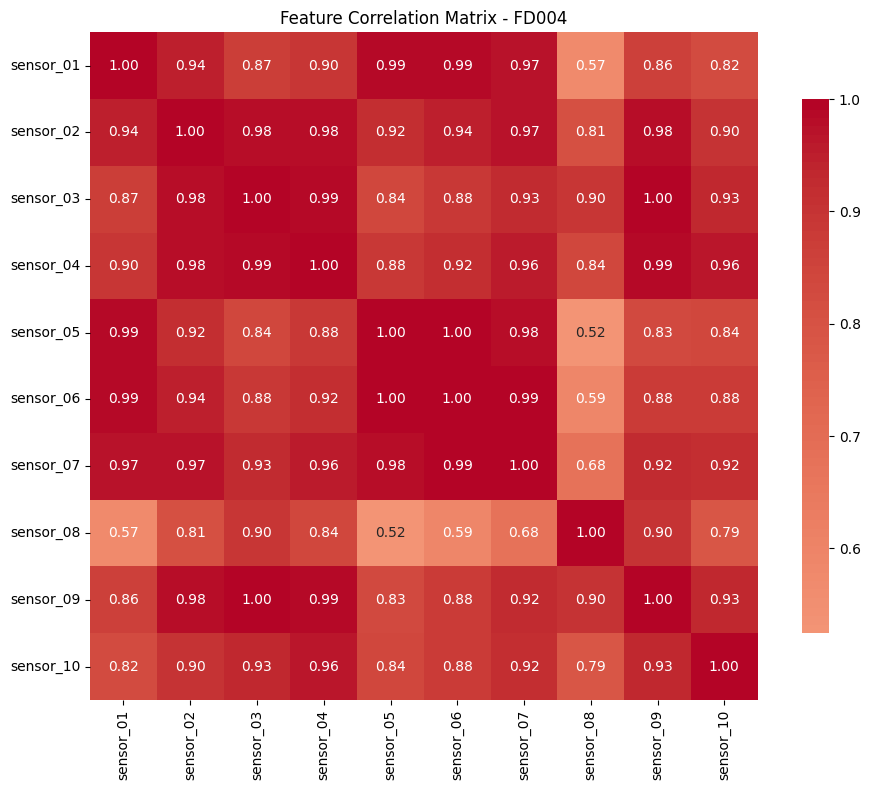


⚙️ STEP 3: Optimized data processing...
🧹 Cleaning data (NASA C-MAPSS style) for FD004...
   Removed 6 noisy sensors: ['sensor_01', 'sensor_05', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
   Using 15 sensor columns
   Calculating training RUL with early warning...
   RUL range: 0.0 to 150.0
🔧 Engineering optimized features (window=15)...
   Using 14 critical sensors
   Total optimized features: 54
📊 Normalizing data...
   Normalized 50 features

🔄 STEP 4: Preparing sequences with engine IDs...
🔄 Creating sequences with engine IDs (length=50)...
   Training: (48799, 50, 50) sequences from 249 engines
   Test: (248, 50, 50) sequences from 248 engines

🎯 STEP 5: Training with engine-based validation...
🛡️ Creating validation split by ENGINE ID (no data leakage)...
   Training engines: 199
   Validation engines: 50
   Training sequences: (39344, 50, 50)
   Validation sequences: (9455, 50, 50)

🔨 STEP 6: Training early-warning models...
🔨 Training early-warning optimized models...

615/615 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - early_warning_accuracy: 0.8229 - early_warning_loss: 0.3696 - loss: 5981.3511 - rul_prediction_loss: 5981.2373 - rul_prediction_mae: 59.6566 - rul_prediction_mse: 5677.7202 - val_early_warning_accuracy: 0.8865 - val_early_warning_loss: 0.2566 - val_loss: 2319.0640 - val_rul_prediction_loss: 2330.5142 - val_rul_prediction_mae: 32.2826 - val_rul_prediction_mse: 1656.8168 - learning_rate: 0.0010
Epoch 2/100
611/615 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - early_warning_accuracy: 0.9036 - early_warning_loss: 0.2076 - loss: 1780.0045 - rul_prediction_loss: 1779.9419 - rul_prediction_mae: 27.5983 - rul_prediction_mse: 1258.7515
Epoch 2: val_loss did not improve from 2319.06396
615/615 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - early_warning_accuracy: 0.9037 - early_warning_loss: 0.2076 - loss: 1779.3641 - rul_prediction_loss: 1779.3030 - rul_prediction_mae: 27.5935 - rul_prediction_mse: 1258.3833 - val_early_warning_accuracy: 0.8464 - val_early_warning_loss: 0.

615/615 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 10174.0938 - rul_loss: 10173.8594 - rul_mae: 90.8414 - rul_mse: 10173.8496 - warning_accuracy: 0.7573 - warning_loss: 0.4584 - val_loss: 5149.2812 - val_rul_loss: 5140.9297 - val_rul_mae: 63.6448 - val_rul_mse: 5140.4375 - val_warning_accuracy: 0.8933 - val_warning_loss: 0.2528 - learning_rate: 0.0010
Epoch 2/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3893.6924 - rul_loss: 3893.6079 - rul_mae: 56.9392 - rul_mse: 3886.6631 - warning_accuracy: 0.9240 - warning_loss: 0.1654
Epoch 2: val_loss improved from 5149.28125 to 2744.69482, saving model to /content/models/early_warning_ensemble_best.h5


615/615 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 3891.8223 - rul_loss: 3891.7363 - rul_mae: 56.9214 - rul_mse: 3884.7751 - warning_accuracy: 0.9240 - warning_loss: 0.1654 - val_loss: 2744.6948 - val_rul_loss: 2756.5999 - val_rul_mae: 34.1618 - val_rul_mse: 1833.2672 - val_warning_accuracy: 0.9065 - val_warning_loss: 0.2657 - learning_rate: 0.0010
Epoch 3/100
614/615 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 873.7744 - rul_loss: 873.7061 - rul_mae: 22.1746 - rul_mse: 750.7375 - warning_accuracy: 0.9405 - warning_loss: 0.1374
Epoch 3: val_loss did not improve from 2744.69482
615/615 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 873.4406 - rul_loss: 873.3722 - rul_mae: 22.1673 - rul_mse: 750.3349 - warning_accuracy: 0.9406 - warning_loss: 0.1374 - val_loss: 3375.7949 - val_rul_loss: 3393.6460 - val_rul_mae: 28.2858 - val_rul_mse: 1335.8998 - val_warning_accuracy: 0.9131 - val_warning_loss: 0.2699 - learning_rate: 0.0010
Epoch 4/100
613/615 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 594.3558

615/615 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 594.2047 - rul_loss: 594.1481 - rul_mae: 16.4543 - rul_mse: 433.1006 - warning_accuracy: 0.9503 - warning_loss: 0.1126 - val_loss: 2701.1099 - val_rul_loss: 2710.5525 - val_rul_mae: 29.2071 - val_rul_mse: 1396.9165 - val_warning_accuracy: 0.9118 - val_warning_loss: 0.2762 - learning_rate: 0.0010
Epoch 5/100
614/615 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 474.6413 - rul_loss: 474.5919 - rul_mae: 14.7709 - rul_mse: 350.5013 - warning_accuracy: 0.9569 - warning_loss: 0.0986
Epoch 5: val_loss did not improve from 2701.10986
615/615 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 474.5959 - rul_loss: 474.5463 - rul_mae: 14.7702 - rul_mse: 350.4679 - warning_accuracy: 0.9569 - warning_loss: 0.0986 - val_loss: 2924.4299 - val_rul_loss: 2942.1353 - val_rul_mae: 28.8442 - val_rul_mse: 1407.3708 - val_warning_accuracy: 0.9120 - val_warning_loss: 0.2872 - learning_rate: 0.0010
Epoch 6/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 442.2652 - 

615/615 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 355.8519 - rul_loss: 355.8217 - rul_mae: 12.8172 - rul_mse: 261.1334 - warning_accuracy: 0.9749 - warning_loss: 0.0626 - val_loss: 2688.3755 - val_rul_loss: 2697.6226 - val_rul_mae: 30.7784 - val_rul_mse: 1537.5245 - val_warning_accuracy: 0.9068 - val_warning_loss: 0.3515 - learning_rate: 0.0010
Epoch 12/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 337.9745 - rul_loss: 337.9435 - rul_mae: 12.5226 - rul_mse: 250.5529 - warning_accuracy: 0.9740 - warning_loss: 0.0622
Epoch 12: val_loss did not improve from 2688.37549
615/615 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 337.9730 - rul_loss: 337.9423 - rul_mae: 12.5226 - rul_mse: 250.5511 - warning_accuracy: 0.9740 - warning_loss: 0.0622 - val_loss: 3028.8169 - val_rul_loss: 3052.8452 - val_rul_mae: 29.2661 - val_rul_mse: 1431.7633 - val_warning_accuracy: 0.8989 - val_warning_loss: 0.4456 - learning_rate: 0.0010
Epoch 13/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 332.9075

615/615 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 5733.7480 - mae: 57.0918 - mse: 4816.0425 - val_loss: 2407.3611 - val_mae: 33.2646 - val_mse: 1721.4274 - learning_rate: 0.0010
Epoch 2/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1725.3275 - mae: 27.4428 - mse: 1216.0527
Epoch 2: val_loss improved from 2407.36108 to 2157.06006, saving model to /content/models/lstm_asymmetric_best.h5


615/615 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 1725.1702 - mae: 27.4414 - mse: 1215.9501 - val_loss: 2157.0601 - val_mae: 29.6566 - val_mse: 1409.4453 - learning_rate: 0.0010
Epoch 3/100
614/615 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1457.2930 - mae: 25.0355 - mse: 1036.5962
Epoch 3: val_loss improved from 2157.06006 to 2039.17041, saving model to /content/models/lstm_asymmetric_best.h5


615/615 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 1457.2196 - mae: 25.0347 - mse: 1036.5592 - val_loss: 2039.1704 - val_mae: 31.1285 - val_mse: 1597.7633 - learning_rate: 0.0010
Epoch 4/100
614/615 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1265.5449 - mae: 23.2523 - mse: 910.3215
Epoch 4: val_loss did not improve from 2039.17041
615/615 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 1265.3157 - mae: 23.2498 - mse: 910.1514 - val_loss: 2403.7856 - val_mae: 32.2540 - val_mse: 1748.0675 - learning_rate: 0.0010
Epoch 5/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 938.3313 - mae: 19.7830 - mse: 682.7518
Epoch 5: val_loss did not improve from 2039.17041
615/615 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 938.1825 - mae: 19.7812 - mse: 682.6417 - val_loss: 2748.5044 - val_mae: 29.4527 - val_mse: 1475.3293 - learning_rate: 0.0010
Epoch 6/100
613/615 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 587.1769 - mae: 15.4260 - mse: 431.7293
Epoch 6: val_loss did not improve from 2039.17041
615/615 ━

615/615 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 4253.0088 - mae: 47.8570 - mse: 3859.6633 - val_loss: 2492.5535 - val_mae: 32.1165 - val_mse: 1725.4126 - learning_rate: 0.0010
Epoch 2/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2034.4059 - mae: 30.6357 - mse: 1497.5195
Epoch 2: val_loss improved from 2492.55347 to 2419.45605, saving model to /content/models/cnn_lstm_asymmetric_best.h5


615/615 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 2034.3271 - mae: 30.6348 - mse: 1497.4465 - val_loss: 2419.4561 - val_mae: 32.0893 - val_mse: 1640.3022 - learning_rate: 0.0010
Epoch 3/100
613/615 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1786.3268 - mae: 28.1534 - mse: 1294.2352
Epoch 3: val_loss did not improve from 2419.45605
615/615 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 1785.8357 - mae: 28.1493 - mse: 1293.8925 - val_loss: 2446.9426 - val_mae: 34.4626 - val_mse: 1958.0184 - learning_rate: 0.0010
Epoch 4/100
613/615 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1454.6423 - mae: 25.1037 - mse: 1050.5978
Epoch 4: val_loss did not improve from 2419.45605
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 1454.2516 - mae: 25.1000 - mse: 1050.3153 - val_loss: 2867.1062 - val_mae: 32.0405 - val_mse: 1717.4918 - learning_rate: 0.0010
Epoch 5/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1176.2271 - mae: 22.4896 - mse: 849.9387
Epoch 5: val_loss did not improve from 2419.45605
61

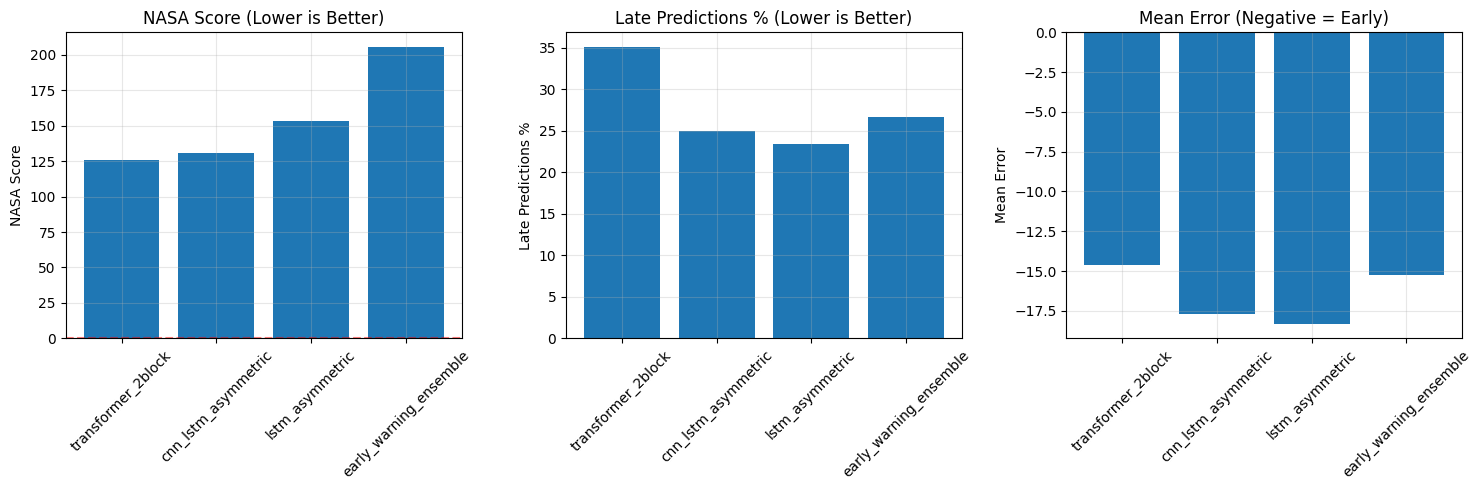


📊 PREDICTION ERROR ANALYSIS - FD004
   Best Model: transformer_2block
   Total predictions: 248
   Late predictions (dangerous): 96 (38.7%)
   Early predictions (safe): 152 (61.3%)
   Accurate predictions (±5 cycles): 27 (10.9%)
   Mean late error: 18.78 cycles
   Mean early error: 35.75 cycles


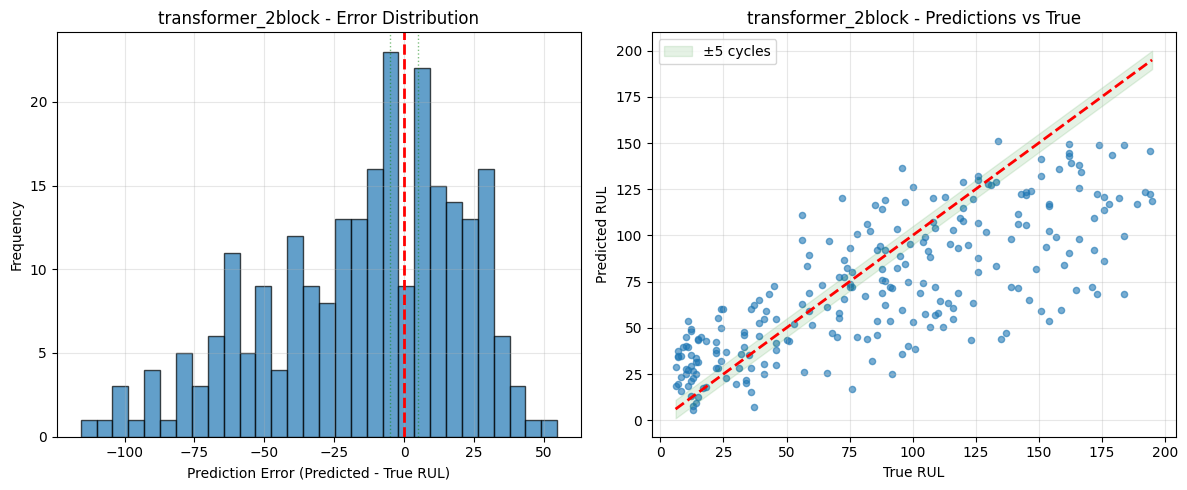


💾 STEP 8: Saving best model...
✅ Best model saved to /content/models/best_model_early_warning_FD004.h5

🚀 STEP 9: Creating deployment package...
📦 Creating deployment package...


✅ Deployment package created in /content/deployment_FD004
  adding: deployment_FD004/ (stored 0%)
  adding: deployment_FD004/model_summary.txt (deflated 91%)
  adding: deployment_FD004/feature_columns.csv (deflated 74%)
  adding: deployment_FD004/predictor.py (deflated 64%)
  adding: deployment_FD004/requirements.txt (deflated 14%)
  adding: deployment_FD004/scaler.pkl (deflated 31%)
📦 Zip file created: /content/deployment_package_FD004.zip

✅ OPTIMIZED WORKFLOW COMPLETE FOR FD004
✅ FD004 analysis complete

🏆 DATASET COMPARISON

Dataset         Best Model      RMSE       MAE  NASA_Score    Late_%
  FD001    lstm_asymmetric 20.148662 15.248660    5.746810 16.000000
  FD002    lstm_asymmetric 31.652001 23.070297   58.311132 22.779923
  FD003    lstm_asymmetric 19.080871 14.432765    5.660052 14.000000
  FD004 transformer_2block 38.035156 29.181688  125.662124 35.080645


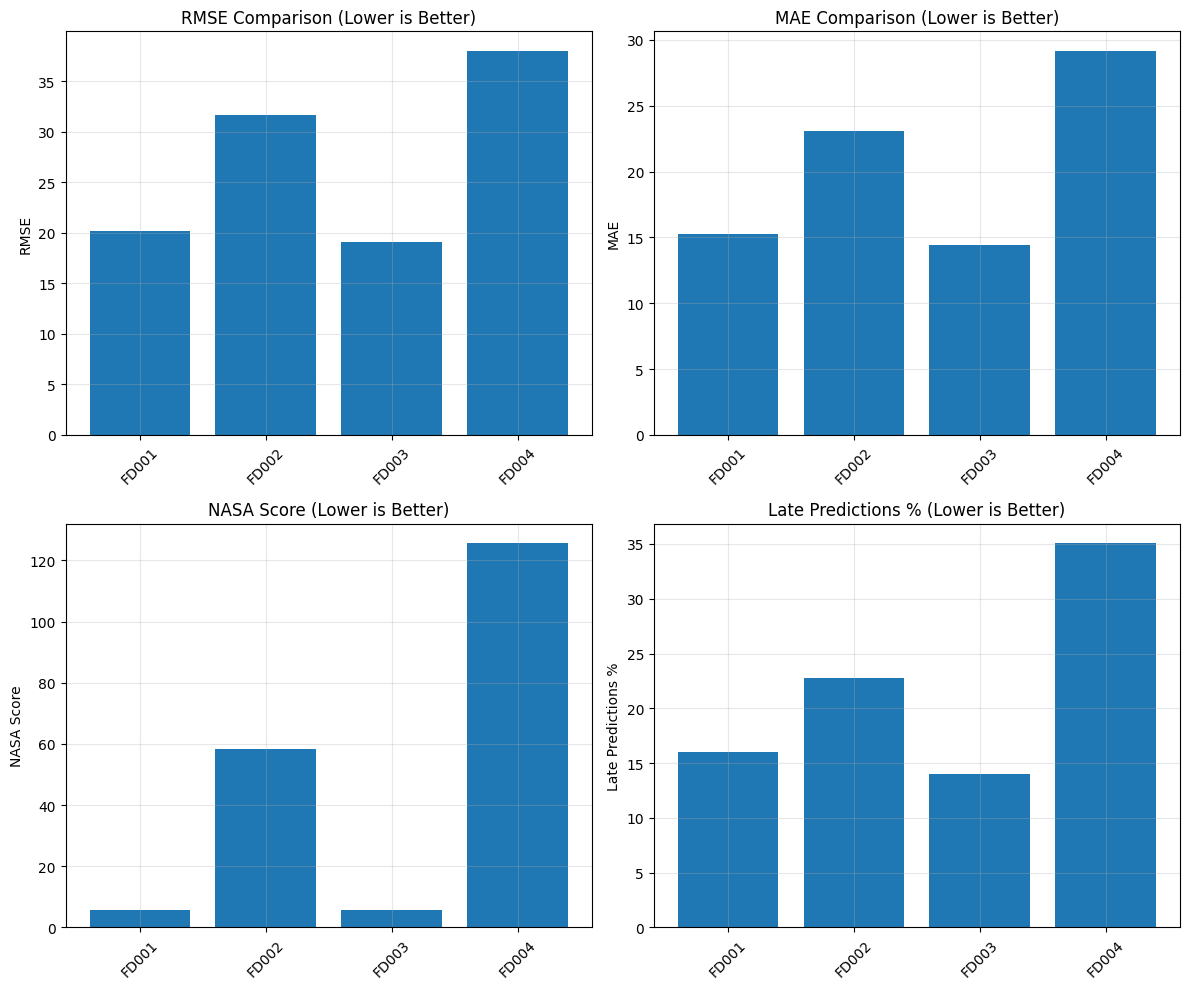


📥 DOWNLOAD LINKS:
   Models: /content/models/
   Results: /content/results/
   Deployment Package: /content/deployment_package_FD002.zip

🎯 SYSTEM READY FOR DEPLOYMENT

Key Improvements Applied:
1. ✅ Fixed data leakage (engine-based validation split)
2. ✅ NASA asymmetric loss (penalizes late predictions)
3. ✅ Removed noisy sensors (NASA recommendations)
4. ✅ Shorter sequences for FD001 (30 cycles)
5. ✅ Deeper transformers for FD001 (2 blocks)
6. ✅ Multi-task learning with early warning

Next steps:
1. Download the deployment package from /content/deployment_package_*.zip
2. Deploy using TensorFlow Serving or as a REST API
3. Integrate with real-time monitoring system
4. Set up alerting for maintenance teams

Thank you for using the Advanced Predictive Maintenance System! 🚀


In [ ]:
# =============================================
# 12. MAIN EXECUTION
# =============================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("🤖 ADVANCED AIRCRAFT ENGINE PREDICTIVE MAINTENANCE SYSTEM")
    print("🎯 OPTIMIZED FOR EARLY FAILURE DETECTION")
    print("="*70)

    # Check available datasets
    if not available_datasets:
        print("⚠️ No datasets found. Please check your uploaded zip file.")
        print("Trying to load any available data...")

        # Try to load any data file
        all_txt_files = list(Path('/content/data').rglob('*.txt'))
        if all_txt_files:
            print(f"Found {len(all_txt_files)} text files. Attempting to load...")
            # Create a mock dataset
            available_datasets['CUSTOM'] = {
                'train': all_txt_files[0],
                'test': all_txt_files[1] if len(all_txt_files) > 1 else all_txt_files[0],
                'rul': all_txt_files[2] if len(all_txt_files) > 2 else None
            }

    # Ask user which dataset to process
    print(f"\n📁 Available datasets: {list(available_datasets.keys())}")

    if len(available_datasets) == 1:
        dataset_to_process = list(available_datasets.keys())[0]
        print(f"📊 Processing the only available dataset: {dataset_to_process}")
    else:
        dataset_to_process = input(f"📝 Enter dataset to process {list(available_datasets.keys())}: ").strip()
        if dataset_to_process not in available_datasets:
            dataset_to_process = list(available_datasets.keys())[0]
            print(f"⚠️ Invalid selection. Defaulting to {dataset_to_process}")

    # Run optimized workflow
    trainer, processor = run_optimized_workflow(dataset_to_process)

    # Ask if user wants to analyze all datasets
    if len(available_datasets) > 1:
        analyze_all = input("\n🔍 Analyze all datasets? (y/n): ").strip().lower()
        if analyze_all == 'y':
            results = analyze_all_datasets()

    # Provide download links
    print("\n📥 DOWNLOAD LINKS:")
    print(f"   Models: /content/models/")
    print(f"   Results: /content/results/")
    print(f"   Deployment Package: /content/deployment_package_{dataset_to_process}.zip")

    # Create final summary
    print("\n" + "="*70)
    print("🎯 SYSTEM READY FOR DEPLOYMENT")
    print("="*70)
    print("\nKey Improvements Applied:")
    print("1. ✅ Fixed data leakage (engine-based validation split)")
    print("2. ✅ NASA asymmetric loss (penalizes late predictions)")
    print("3. ✅ Removed noisy sensors (NASA recommendations)")
    print("4. ✅ Shorter sequences for FD001 (30 cycles)")
    print("5. ✅ Deeper transformers for FD001 (2 blocks)")
    print("6. ✅ Multi-task learning with early warning")
    print("\nNext steps:")
    print("1. Download the deployment package from /content/deployment_package_*.zip")
    print("2. Deploy using TensorFlow Serving or as a REST API")
    print("3. Integrate with real-time monitoring system")
    print("4. Set up alerting for maintenance teams")
    print("\nThank you for using the Advanced Predictive Maintenance System! 🚀")

In [ ]:
# =============================================
# 13. QUICK TEST (OPTIONAL)
# =============================================

# Uncomment to run a quick test
# trainer, processor = run_optimized_workflow('FD001')